<a href="https://colab.research.google.com/github/UN-GCPDS/Curso-Corto-LLMs/blob/main/2.Entrenamiento_Tabnet/Entrenamiento_Tabnet_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo UNAL CHEC](https://github.com/UN-GCPDS/curso_IA_CHEC/blob/main/logo_unal_chec.jpg?raw=1)

# **Entrenamiento modelo Tabnet**

## **Descripción**

Entrenamiento de modelo Tabnet bajo diversas condiciones.

### **Profesor - Sesión 1:** Andrés Marino Álvarez Meza y Diego Armando Pérez Rosero

# Datos

**TabNet para criticidad en redes de media tensión — Planteamiento y datos (Regresión)**

Sea el conjunto de datos

$$
\mathbf{X}\in\mathbb{R}^{N\times M},\qquad
\mathbf{y}\in\mathbb{R}^{N}.
$$

Cada fila de $\mathbf{X}$ representa un evento o periodo entre 2019 y 2024 y contiene las características de los elementos asociados al equipo que operó. El vector $\mathbf{y}$ almacena el valor continuo del indicador a modelar (SAIDI o SAIFI) para ese mismo evento/periodo.

Definimos

$$
\mathcal{F}:\mathcal{X}\subseteq\mathbb{R}^{M}\to\mathbb{R},\qquad
\hat{y}=\mathcal{F}(\mathbf{x})
=
\bigl(\,\breve{f}_{L}\circ \breve{f}_{L-1}\circ \cdots \circ \breve{f}_{1}\,\bigr)(\mathbf{x}),
$$

donde $\breve{f}_{l}(\cdot)$ denota el $l$-ésimo bloque del modelo ($l\in\{1,\dots,L\}$) y $\circ$ es el operador de composición.

En caso multisalida para $(\text{SAIDI},\text{SAIFI})$, se toma $\mathcal{F}:\mathbb{R}^{M}\to\mathbb{R}^{2}$ y $\mathbf{y}\in\mathbb{R}^{N\times 2}$.
![Logo UNAL CHEC](https://raw.githubusercontent.com/Daprosero/Deep-Convolutional-Generative-Adversarial-Network/refs/heads/master/Mercados%20CHEC.png)

In [ ]:
#@title Librerías
# Instalación de paquetes necesarios
!pip install -q gdown
!pip install openTSNE
!pip install pytorch-tabnet optuna
!pip install wget --quiet

# Importación de librerías necesarias
import optuna
import warnings
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.neighbors import NearestNeighbors
from pytorch_tabnet.tab_model import TabNetRegressor, TabNetClassifier
from pytorch_tabnet.augmentations import RegressionSMOTE
from google.colab import drive
import tensorflow as tf
import tensorflow_probability as tfp
import os
from pathlib import Path
import math
import wget
!gdown --id 1o_fZIhk6ErrtrM3eVZPF9s2qj8l4FoqS -O SuperEventos_Criticidad_AguasAbajo_CODEs.zip
!gdown --id 1lBrseLoEmr6-VwNSCHOp2zuc4sKKrkbQ -O model.zip
!gdown --id 16VIuHLgPGpX4J723Wd48UAPhHivLuUaH -O Data_CHEC.zip

import zipfile
import os

zip_path = "SuperEventos_Criticidad_AguasAbajo_CODEs.zip"
extract_dir = "CHEC"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

zip_path = "model.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

zip_path = "Data_CHEC.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Supresión de warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning)

# Función auxiliar para etiquetas
def get_labels(x: pd.Series) -> pd.Series:
    labels, _ = pd.factorize(x)
    return pd.Series(labels, name=x.name, index=x.index)

# Definición de funciones personalizadas de pérdida
def my_mse_loss_fn(y_pred, y_true):
    mse_loss = (y_true - y_pred) ** 2
    return torch.mean(mse_loss)
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_var_band(
    df,
    var_token,
    row_index=0,
    hours_back=24,
    col_patterns=None,
    display_name=None,
    units=None,
    event_label="evento reportado",
):
    """
    Grafica una variable climática en una franja de horas hacia atrás.

    Parámetros
    ----------
    df : pd.DataFrame
        Contiene columnas por hora para la variable elegida.
        Ejemplos de nombres soportados automáticamente:
        - 'h0-<var>', 'h1-<var>', ..., 'h24-<var>'
        - '<var>_h0', '<var>_h1', ...
        con separadores '_' o '-'.

    var_token : str
        Nombre base de la variable en los nombres de columna (p.ej. 'wind_gust_spd',
        'air_temp', 'precip'). Debe coincidir con lo que aparece en las columnas.

    row_index : int
        Fila (evento) a graficar.

    hours_back : int
        Cuántas horas hacia atrás mostrar.

    col_patterns : list[str] | None
        Lista de regex opcionales para detectar columnas por hora.
        Si None, se generan automáticamente a partir de var_token.

    display_name : str | None
        Etiqueta legible para el eje Y (p.ej. 'Ráfaga de viento').
        Si None, se usa var_token.

    units : str | None
        Unidades para concatenar en la etiqueta Y (p.ej. 'm/s', '°C', 'mm').

    event_label : str
        Texto para la flecha en la hora 0.
    """
    # --- 1) Preparar patrones de columnas ---
    if col_patterns is None:
        # Permitir '_' o '-' (o espacio) entre partes del var_token
        parts = re.split(r'[_\-\s]+', var_token.strip())
        # Construimos un regex que tolere '_' o '-' entre partes
        # ej: 'wind[_-]?gust[_-]?spd'
        var_regex = r'[_-]?'.join(map(re.escape, parts))

        col_patterns = [
            rf'^h(\d{{1,2}})[-_]?{var_regex}$',   # h0-<var>  o  h0_<var>
            rf'^{var_regex}[-_]?h(\d{{1,2}})$',   # <var>-h0  o  <var>_h0
        ]

    # --- 2) Detectar columnas y mapear a hora ---
    hour_to_col = {}
    for c in df.columns:
        for pat in col_patterns:
            m = re.match(pat, str(c), flags=re.IGNORECASE)
            if m:
                h = int(m.group(1))
                hour_to_col[h] = c
                break

    if not hour_to_col:
        raise ValueError(
            f"No se encontraron columnas con horas para la variable '{var_token}'.\n"
            f"Prueba ajustando 'var_token' o pasando 'col_patterns' personalizados."
        )

    # --- 3) Construir serie horas [0..hours_back] si existen, orden ascendente ---
    hours = [h for h in sorted(hour_to_col.keys()) if 0 <= h <= hours_back]
    vals = np.array(
        [pd.to_numeric(df.loc[df.index[row_index], hour_to_col[h]], errors='coerce') for h in hours],
        dtype=float
    )

    # --- 4) Graficar ---
    fig, ax = plt.subplots(figsize=(10, 5))

    # línea y puntos
    ax.plot(hours, vals, marker='o')

    # invertir eje X para que se vea 24 -> 0
    ax.set_xlim(hours_back, 0)

    # franja sombreada
    ymin = np.nanmin(vals) if np.isfinite(np.nanmin(vals)) else 0.0
    ymax = np.nanmax(vals) if np.isfinite(np.nanmax(vals)) else 1.0
    pad  = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
    ax.set_ylim(ymin - pad, ymax + pad)
    ax.axvspan(0, hours_back, alpha=0.15)

    # flecha y etiqueta en hora 0
    y0 = vals[hours.index(0)] if 0 in hours else np.nan
    if not np.isfinite(y0):
        y0 = np.nanmedian(vals) if np.isfinite(np.nanmedian(vals)) else (ymin + ymax) / 2.0

    ax.annotate(
        event_label,
        xy=(0, y0),
        xytext=(max(2, min(4, hours_back*0.15)), y0 + (ymax - y0)*0.15),
        arrowprops=dict(arrowstyle="->", lw=1),
        ha='left', va='bottom'
    )

    # etiquetas
    ylab = display_name if display_name else var_token
    if units:
        ylab = f"{ylab} [{units}]"
    ax.set_xlabel("Horas antes del evento")
    ax.set_ylabel(ylab)
    ax.grid(True, alpha=0.3)

    # ticks principales (24, 18, 12, 6, 0) si corresponde
    xticks = [h for h in [hours_back, 18, 12, 6, 0] if 0 <= h <= hours_back]
    ax.set_xticks(xticks)

    plt.tight_layout()
    plt.show()


# --- Ejemplo de uso:
# plot_wind_gust_band(df=tu_dataframe, row_index=0, hours_back=24)

def my_rmse_loss_fn(y_pred, y_true):
    mse_loss = (y_true - y_pred) ** 2
    mean_mse_loss = torch.mean(mse_loss)
    rmse_loss = torch.sqrt(mean_mse_loss)
    return rmse_loss

def my_mae_loss_fn(y_pred, y_true):
    mae_loss = torch.abs(y_true - y_pred)
    return torch.mean(mae_loss)

def my_mape_loss_fn(y_pred, y_true):
    mape_loss = torch.abs((y_true - y_pred) / y_true) * 100
    return torch.mean(mape_loss)

def my_r2_score_fn(y_pred, y_true):
    total_variance = torch.var(y_true, unbiased=False)
    unexplained_variance = torch.mean((y_true - y_pred) ** 2)
    r2_score = 1 - (unexplained_variance / total_variance)
    return 1-r2_score

# Etapa 0: imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
# ==== Librerías ====
import numpy as np
import cupy as cp
import xgboost as xgb

from cuml.ensemble import RandomForestRegressor as cuRF
from cuml.metrics import r2_score as r2_gpu

# Si quieres comparar con CPU para sanity-check:
from sklearn.metrics import r2_score as r2_cpu
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
# ==== Utilidades ====
def to_cpu(a):
    """Convierte CuPy -> NumPy si aplica."""
    try:
        if isinstance(a, cp.ndarray):
            return cp.asnumpy(a)
    except Exception:
        pass
    return a

def metrics_gpu(y_true_cp, y_pred_cp):
    """MAE, RMSE, R2 calculados en GPU (CuPy)."""
    y_true_cp = cp.asarray(y_true_cp)
    y_pred_cp = cp.asarray(y_pred_cp)
    mae  = float(cp.mean(cp.abs(y_true_cp - y_pred_cp)))
    rmse = float(cp.sqrt(cp.mean((y_true_cp - y_pred_cp)**2)))
    ssr  = float(cp.sum((y_true_cp - y_pred_cp)**2))
    sst  = float(cp.sum((y_true_cp - cp.mean(y_true_cp))**2))
    r2   = 1.0 - ssr / sst if sst > 0 else np.nan
    return mae, rmse, r2

def permutation_importance_rf_gpu(model, X_val_cp, y_val_cp, n_repeats=3, max_feats=None, random_state=42):
    """
    Permutation importance en GPU para RF cuML.
    Devuelve importancia por feature (drop medio de R2 en valid).
    Si max_feats no es None, calcula solo para las primeras max_feats columnas (para acelerar).
    """
    rs = cp.random.RandomState(random_state)
    X_val_cp = cp.asarray(X_val_cp)
    y_val_cp = cp.asarray(y_val_cp)

    # R2 base
    y_pred_base = model.predict(X_val_cp)
    _, _, r2_base = metrics_gpu(y_val_cp, y_pred_base)

    n, d = X_val_cp.shape
    d_eval = d if max_feats is None else int(min(max_feats, d))
    importances = cp.zeros(d, dtype=cp.float32)

    for j in range(d_eval):
        drops = []
        for _ in range(n_repeats):
            Xp = X_val_cp.copy()
            idx = rs.permutation(n)
            Xp[:, j] = Xp[idx, j]  # permutar solo la columna j
            y_pred_p = model.predict(Xp)
            _, _, r2_p = metrics_gpu(y_val_cp, y_pred_p)
            drops.append(r2_base - r2_p)
        importances[j] = cp.mean(cp.asarray(drops))

    return importances  # CuPy array
def regression_metrics(y_true, y_pred):
    mae  = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
    ss_res = float(np.sum((y_true - y_pred)**2))
    ss_tot = float(np.sum((y_true - np.mean(y_true))**2))
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return mae, rmse, r2
class CustomTabNetRegressor(TabNetRegressor):
    def __init__(self, *args, **kwargs):
        super(CustomTabNetRegressor, self).__init__(*args, **kwargs)

    def forward(self, X):
        output, M_loss = self.network(X)
        output = torch.relu(output)
        return output, M_loss

    def predict(self, X):
        device = next(self.network.parameters()).device
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)
        X = X.to(device)
        with torch.no_grad():
            output, _ = self.forward(X)
        return output.cpu().numpy()
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from tqdm import tqdm
from ast import literal_eval
from pandas.api.types import is_numeric_dtype


import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
def make_strat_labels(y_vals, n_bins=3, min_per_class=2):
    """
    Genera etiquetas para estratificar a partir de un objetivo continuo.
    Reduce bins si no hay suficientes muestras por clase.
    """
    y1d = y_vals.reshape(-1)
    for bins in range(n_bins, 1, -1):
        pct = np.linspace(0, 100, bins + 1)[1:-1]
        cuts = np.percentile(y1d, pct)
        if np.any(np.diff(cuts) <= 0):
            continue
        labels = np.digitize(y1d, bins=cuts).astype(int)
        counts = Counter(labels)
        if all(c >= min_per_class for c in counts.values()) and len(counts) > 1:
            return labels
    return None

def stratify_from_df_or_y(df_labels, idx, y_subset, col='NIVEL_C'):
    """Intenta usar df[col] como etiqueta; si falla, usa percentiles en y_subset."""
    try:
        ycat_full = df_labels.loc[:, col].values.astype(int)
        ycat = ycat_full[idx]
        c10 = Counter(ycat)
        if all(v >= 2 for v in c10.values()) and len(c10) > 1:
            return ycat
    except Exception:
        pass
    return make_strat_labels(y_subset[:,0], n_bins=3, min_per_class=2)

def split_subset(X, y, df_labels=None, n_sub=1000, test_size=0.20, seed=42):
    """
    1) Toma un subset aleatorio de tamaño n_sub.
    2) Escala y (MinMax) sobre el subset.
    3) Split train/test con estratificación si es viable.
    4) Split train/valid (20% del train), con re-estratificación si es posible.
    """
    rng = np.random.RandomState(seed)
    n_total = X.shape[0]
    n_sub = min(n_sub, n_total)
    idx_sub = rng.choice(n_total, size=n_sub, replace=False)

    X_sub = X[idx_sub]
    y_sub = y[idx_sub]
    # etiquetas auxiliares para estratificación
    ycat_sub = stratify_from_df_or_y(df_labels, idx_sub, y_sub) if df_labels is not None else make_strat_labels(y_sub[:,0])
    # escalar objetivo en el subset
    scaler = MinMaxScaler()
    y_sub_scaled = scaler.fit_transform(y_sub)

    split_kwargs = dict(test_size=test_size, random_state=seed, shuffle=True)
    if ycat_sub is not None:
        X_tr, X_te, y_tr, y_te, ycat_tr, ycat_te = train_test_split(
            X_sub, y_sub_scaled, ycat_sub, stratify=ycat_sub, **split_kwargs
        )
    else:
        X_tr, X_te, y_tr, y_te = train_test_split(X_sub, y_sub_scaled, **split_kwargs)
        ycat_tr = ycat_te = None

    # Validación (20% del train)
    if ycat_tr is not None:
        y_tr_raw = y_tr[:,0]
        ycat_t = make_strat_labels(y_tr_raw, n_bins=3, min_per_class=2)
        if ycat_t is not None:
            X_tr, X_va, y_tr, y_va, ycat_tr, ycat_va = train_test_split(
                X_tr, y_tr, ycat_tr, test_size=0.20, random_state=seed, stratify=ycat_t
            )
        else:
            X_tr, X_va, y_tr, y_va = train_test_split(
                X_tr, y_tr, test_size=0.20, random_state=seed, shuffle=True
            )
            ycat_va = None
    else:
        X_tr, X_va, y_tr, y_va = train_test_split(
            X_tr, y_tr, test_size=0.20, random_state=seed, shuffle=True
        )
        ycat_va = None

    # Reporte rápido
    print("Originales (conservados):", X_orig.shape, y_orig.shape)
    print(f"Subset de {n_sub}:", X_sub.shape, y_sub.shape)
    print("Train/Valid/Test:", X_tr.shape, X_va.shape, X_te.shape)
    if ycat_sub is not None:
        print("Distribución clases subset:", Counter(ycat_sub))

    return {
        "idx_sub": idx_sub,
        "X_train": X_tr, "X_valid": X_va, "X_test": X_te,
        "y_train": y_tr, "y_valid": y_va, "y_test": y_te
    }
from copy import deepcopy
from sklearn.metrics import r2_score

def eval_and_print(title, clf_model, X_test, y_test):
    """Evalúa R² en escala original (inverse_transform) y lo imprime."""
    y_pred = clf_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{title}: R2={r2:.4f}")
    return r2

def run_three_training_strategies(
    # modelos / kwargs
    clf_base,                   # modelo ya entrenado en la Fase 1 (con warm_start=True)
    model_init_kwargs,          # dict con los kwargs para construir un modelo nuevo idéntico (desde cero)
    # datos antiguos (Fase 1)
    X_train_old, y_train_old,   # típicamente (X_train, y_train[:,0:1]) de los 1000
    X_test_old, y_test_old,  # test y scaler usados en la Fase 1
    # datos nuevos (Fase 2)
    X_tr_new, y_tr_new,         # train de los 500
    X_va_new, y_va_new,         # valid de los 500 (para early stopping)
    X_te_new, y_te_new,  # test nuevo y su scaler
    # entrenamiento
    batch_size, virtual_batch_size, aug,
    max_epochs_ft_inc=200, patience_ft_inc=70,
    max_epochs_ft_new=200, patience_ft_new=70,
    max_epochs_scratch=200, patience_scratch=70,
    lower_lr_factor=0.1, min_lr=1e-5
):
    """
    Ejecuta:
      A) Fine-tuning incremental (old + new)
      B) Fine-tuning no incremental (solo new)
      C) Desde cero (old + new)
    y evalúa R² en test viejo y test nuevo (ambos en escala original).
    Devuelve un dict con los R².
    """
    results = {}

    # =============================
    # A) Fine-tuning incremental
    # =============================
    clf_ft_inc = deepcopy(clf_base)  # copia del clf ya entrenado
    # bajar LR para fine-tune (opcional, recomendado)
    if hasattr(clf_ft_inc, "_optimizer"):
        for g in clf_ft_inc._optimizer.param_groups:
            g["lr"] = max(g["lr"] * lower_lr_factor, min_lr)

    X_inc = np.concatenate([X_train_old, X_tr_new], axis=0)
    y_inc = np.concatenate([y_train_old, y_tr_new], axis=0)

    clf_ft_inc.fit(
        X_train=X_inc, y_train=y_inc,
        eval_set=[(X_inc, y_inc), (X_va_new, y_va_new)],
        eval_name=['train_inc', 'valid_new'],
        eval_metric=['mae'], loss_fn=my_r2_score_fn,
        max_epochs=max_epochs_ft_inc, patience=patience_ft_inc,
        batch_size=batch_size, virtual_batch_size=virtual_batch_size,
        num_workers=1, drop_last=False, augmentations=aug,
    )

    print("\n== Desempeño: Fine-tuning incremental ==")
    r2_old_inc = eval_and_print("Test viejo (FT incremental)", clf_ft_inc, X_test_old, y_test_old)
    r2_new_inc = eval_and_print("Test nuevo (FT incremental)", clf_ft_inc, X_te_new,  y_te_new)
    results["fine_tune_incremental"] = {"R2_old_test": r2_old_inc, "R2_new_test": r2_new_inc, "model": clf_ft_inc}

    # =============================
    # B) Fine-tuning no incremental (solo nuevos)
    # =============================
    clf_ft_new = deepcopy(clf_base)
    if hasattr(clf_ft_new, "_optimizer"):
        for g in clf_ft_new._optimizer.param_groups:
            g["lr"] = max(g["lr"] * lower_lr_factor, min_lr)

    clf_ft_new.fit(
        X_train=X_tr_new, y_train=y_tr_new,
        eval_set=[(X_tr_new, y_tr_new), (X_va_new, y_va_new)],
        eval_name=['train_new', 'valid_new'],
        eval_metric=['mae'], loss_fn=my_r2_score_fn,
        max_epochs=max_epochs_ft_new, patience=patience_ft_new,
        batch_size=batch_size, virtual_batch_size=virtual_batch_size,
        num_workers=1, drop_last=False, augmentations=aug,
    )

    print("\n== Desempeño: Fine-tuning NO incremental (solo nuevos) ==")
    r2_old_new = eval_and_print("Test viejo (FT no incremental)", clf_ft_new, X_test_old, y_test_old)
    r2_new_new = eval_and_print("Test nuevo (FT no incremental)", clf_ft_new, X_te_new,  y_te_new)
    results["fine_tune_only_new"] = {"R2_old_test": r2_old_new, "R2_new_test": r2_new_new, "model": clf_ft_new}

    # =============================
    # C) Desde cero (cumulative old+new)
    # =============================
    # model_init_kwargs debe contener todo lo necesario para reconstruir el TabNet
    clf_scratch = CustomTabNetRegressor(**model_init_kwargs)

    X_cum = np.concatenate([X_train_old, X_tr_new], axis=0)
    y_cum = np.concatenate([y_train_old, y_tr_new], axis=0)

    clf_scratch.fit(
        X_train=X_cum, y_train=y_cum,
        eval_set=[(X_cum, y_cum), (X_va_new, y_va_new)],
        eval_name=['train_cum', 'valid_new'],
        eval_metric=['mae'], loss_fn=my_r2_score_fn,
        max_epochs=max_epochs_scratch, patience=patience_scratch,
        batch_size=batch_size, virtual_batch_size=virtual_batch_size,
        num_workers=1, drop_last=False, augmentations=aug,
    )

    print("\n== Desempeño: Desde cero (old+new) ==")
    r2_old_sc = eval_and_print("Test viejo (desde cero)", clf_scratch, X_test_old, y_test_old)
    r2_new_sc = eval_and_print("Test nuevo (desde cero)", clf_scratch, X_te_new,  y_te_new)
    results["from_scratch"] = {"R2_old_test": r2_old_sc, "R2_new_test": r2_new_sc, "model": clf_scratch}
    return results
def pick_new_indices(n_new=500, seed=123):
    rng = np.random.RandomState(seed)
    universe = np.setdiff1d(np.arange(X.shape[0]), splits_1000["idx_sub"], assume_unique=True)
    n_new = min(n_new, universe.shape[0])
    return rng.choice(universe, size=n_new, replace=False)
Xdata = df = pd.read_pickle('/content/CHEC/SuperEventos_Criticidad_AguasAbajo_CODEs.pkl')
Xdata = Xdata[Xdata['duracion_h'] <= 100]
# ---------------------------------------------------------
# Etapa 1: seleccionar objetivo (SAIDI o SAIFI) con forma (N,1)
# Extraer variables objetivo
Dur_h = Xdata['duracion_h'].values
SAIDI = Xdata['SAIDI'].values
df1=Xdata.copy()
# Eliminar columnas no utilizadas
Xdata.drop(['inicio_evento', 'h0-solar_rad', 'h0-uv', 'h1-solar_rad', 'h1-uv', 'h2-solar_rad', 'h2-uv', 'h3-solar_rad', 'h3-uv',
            'h4-solar_rad', 'h4-uv', 'h5-solar_rad', 'h5-uv', 'h19-solar_rad', 'h19-uv', 'h20-solar_rad', 'h20-uv',
            'h21-solar_rad', 'h21-uv', 'h22-solar_rad', 'h22-uv', 'h23-solar_rad', 'h23-uv', 'evento', 'fin', 'inicio',
            'cnt_usus', 'DEP', 'MUN', 'FECHA', 'NIVEL_C', 'VALOR_C', 'TRAMOS_AGUAS_ABAJO', 'EQUIPOS_PUNTOS',
            'PUNTOS_POLIGONO', 'LONGITUD2', 'LATITUD2', 'FECHA_C','TRAMOS_AGUAS_ABAJO_CODES','ORDER_'],
           inplace=True, axis=1)

# Definir la variable objetivo y eliminarla del conjunto de características
target = ['SAIFI', 'SAIDI', 'duracion_h']
y1 = Xdata[target].values
Xdata.drop(target, axis=1, inplace=True)
y = y1[:, 0:1].astype('float32')

# Copia de trabajo de X
df = Xdata.copy()

# ---------------------------------------------------------
# Etapa 2: tipificar columnas
NUMERIC_COLUMNS = df.select_dtypes(include=['number']).columns.tolist()
CATEGORICAL_COLUMNS = df.select_dtypes(include=['object', 'category']).columns.tolist()

# ---------------------------------------------------------
# Etapa 3: imputación numérica
max_values = {}
for col in NUMERIC_COLUMNS:
    max_value = pd.to_numeric(df[col], errors='coerce').max()
    if pd.isna(max_value):
        max_value = 0.0
    max_values[col] = max_value
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(-10.0 * max_value)

# ---------------------------------------------------------
# Etapa 4: codificación categórica
label_encoders = {}
categorical_dims = {}
for col in CATEGORICAL_COLUMNS:
    enc = LabelEncoder()
    s = df[col].astype(str).fillna("no aplica")
    enc.fit(s)
    df[col] = enc.transform(s)
    label_encoders[col] = enc
    categorical_dims[col] = len(enc.classes_)

# ---------------------------------------------------------
# Etapa 5: construir matrices X, y
unused_feat = []
# Si Xdata NO incluye el target, basta con tomar todas las columnas
features = [c for c in df.columns if c not in unused_feat]
X = df[features].values.astype('float32')


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1o_fZIhk6ErrtrM3eVZPF9s2qj8l4FoqS
From (redirected): https://drive.google.com/uc?id=1o_fZIhk6ErrtrM3eVZPF9s2qj8l4FoqS&confirm=t&uuid=be8bd5d8-9b06-4fcf-9f09-89d4ef149d5a
To: /content/SuperEventos_Criticidad_AguasAbajo_CODEs.zip
100% 214M/214M [00:02<00:00, 99.1MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1lBrseLoEmr6-VwNSCHOp2zuc4sKKrkbQ
From (redirected): https://drive.google.com/uc?id=1lBrseLoEmr6-VwNSCHOp2zuc4sKKrkbQ&confirm=t&uuid=343fda9b-a2d9-49cf-a50d-3d8ee5a7

# Incorporación de nuevas características

In [ ]:
Xdata = df = pd.read_pickle('/content/CHEC/SuperEventos_Criticidad_AguasAbajo_CODEs.pkl')
Xdata = Xdata[Xdata['duracion_h'] <= 100]
Xdata = Xdata.iloc[:1000]
Rayos=pd.read_pickle('/content/CHEC/Data_CHEC/Rayos.pkl')
Rayos['FECHA'] = pd.to_datetime(Rayos['FECHA'])
Vegetacion=pd.read_pickle('/content/CHEC/Data_CHEC/Vegetacion.pkl')
Vegetacion['LATITUD'] = Vegetacion['LATITUD'].astype(float)
Vegetacion['LONGITUD'] = Vegetacion['LONGITUD'].astype(float)

In [ ]:
Rayos.head()

,ID,LATITUD,LONGITUD,ALTITUD,TIPO,CORRIENTE,ERROR,CODE,FPARENT,DISTANCIA_A_NODO,FECHA,DEP,MUN
0,202009191522446,4.9487,-75.5995,"12,4",2,-5.3,"0,016",1657,CHA23L16,78.252413,2020-09-03 14:15:22,CALDAS,VILLAMARÍA
1,2020076142486,4.9488,-75.7033,0,1,-5.8,"0,061",58412,INS23L13,24.710599,2020-07-10 01:01:42,RISARALDA,SANTA ROSA DE CABAL
2,20200784256395,4.9488,-75.6958,"6,6",2,5.2,"0,016",4244,INS23L13,35.126961,2020-07-04 03:42:56,RISARALDA,SANTA ROSA DE CABAL
3,202008193652495,4.6288,-75.6113,"10,1",2,5.0,"0,003",A186,ROS40L21,289.085969,2020-08-22 14:36:52,QUINDÍO,CIRCASIA
4,20200823350497,4.9488,-76.0051,0,1,-24.7,"0,145",36021,BOA23L14,354.305040,2020-08-13 18:35:04,RISARALDA,BALBOA


In [ ]:
Rayos.columns

Index(['ID', 'LATITUD', 'LONGITUD', 'ALTITUD', 'TIPO', 'CORRIENTE', 'ERROR',
       'CODE', 'FPARENT', 'DISTANCIA_A_NODO', 'FECHA', 'DEP', 'MUN'],
      dtype='object')

In [ ]:
Vegetacion.head()

,NOM_COMUN,TIPO_VEGET,ESTADO_INICIAL,FECHA,LADO_RED,DAP_ESTIM,LONG_INTER,TIPO_INTER,NIVEL_RIES,CIRCUITO_TRAMO,NODO_1,NODO_2,LONGITUD,LATITUD,DEP,MUN
0,YARUMO,Bosque natural,Nuevo,2023-11-30,Debajo,22,6,Rocería,Medio,ESM40L27,A06084,A06085,-75.714305,5.013050,RISARALDA,MARSELLA
1,GUADUA,Guadual,Nuevo,2023-11-30,Debajo,11,6,Tala,Medio,ESM40L27,A06089,A06090,-75.726387,5.023843,RISARALDA,MARSELLA
2,MANDARINO,Frutales,Nuevo,2023-11-30,Debajo,28,6,Poda,Alto,ESM40L28,A06059,A06060,-75.645768,4.992025,CALDAS,CHINCHINÁ
3,GUAMO,Cafe/sombrio,Nuevo,2023-11-30,Debajo,45,6,Poda,Medio,ESM40L27,A06070,A06071,-75.674651,4.993295,CALDAS,CHINCHINÁ
4,GUADUA,Guadual,Nuevo,2023-11-30,Debajo,12,6,Tala,Medio,ESM40L27,A06087,A06088,-75.723988,5.018694,RISARALDA,MARSELLA


In [ ]:
Vegetacion.columns

Index(['NOM_COMUN', 'TIPO_VEGET', 'ESTADO_INICIAL', 'FECHA', 'LADO_RED',
       'DAP_ESTIM', 'LONG_INTER', 'TIPO_INTER', 'NIVEL_RIES', 'CIRCUITO_TRAMO',
       'NODO_1', 'NODO_2', 'LONGITUD', 'LATITUD', 'DEP', 'MUN'],
      dtype='object')

In [ ]:
Xdata.shape

(1000, 355)

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from pandas.api.types import is_numeric_dtype
from ast import literal_eval
from tqdm import tqdm

def enriquecer_eventos_con_rayos_y_vegetacion(
    Eventos: pd.DataFrame,
    Rayos: pd.DataFrame,
    Vegetacion: pd.DataFrame,
    *,
    radio_rayos: float = 0.005,        # ~0.5 km en grados aprox.
    ventana_dias: int = 1,             # [inicio - ventana_dias, inicio]
    radio_vegetacion: float = 0.0003,  # ~30 m aprox. en grados
    veg_vars: list | None = None,      # variables de interés en Vegetación
    usar_tqdm: bool = True,
    col_lat: str = 'LATITUD',
    col_lon: str = 'LONGITUD'
) -> pd.DataFrame:
    """
    Para cada evento, toma TODAS las (LATITUD,LONGITUD) únicas de su municipio (MUN)
    como puntos de consulta y busca alrededor:
      - RAYOS: dentro de radio_rayos y en la ventana temporal [inicio - ventana_dias, inicio].
      - VEGETACIÓN: dentro de radio_vegetacion (solo espacial).

    Vegetación:
      * 'conteo_vegetacion'
      * Para cada var en veg_vars:
          - Si es numérica (o numérico-like): {mean, median, min, max, std} (std=0 si 1 dato)
          - Si es categórica: {mode}. Si var == 'NOM_COMUN' -> columna 'nombre_comun_mas_frecuente'
    """

    # ---------------------------
    # Normalización de insumos
    # ---------------------------
    Eventos = Eventos.copy()

    # Asegurar tipos numéricos de lat/lon y fecha en Rayos / Vegetación
    for df in (Rayos, Vegetacion, Eventos):
        for c in (col_lat, col_lon):
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors='coerce')

    if 'FECHA' in Rayos.columns:
        Rayos['FECHA'] = pd.to_datetime(Rayos['FECHA'], errors='coerce')
    if 'inicio' in Eventos.columns:
        Eventos['inicio'] = pd.to_datetime(Eventos['inicio'], errors='coerce')

    if 'MUN' not in Eventos.columns:
        raise ValueError("Eventos debe contener la columna 'MUN'.")

    # ---------------------------
    # Helpers
    # ---------------------------
    def _build_kd_by_group(df, key_col='MUN', lat=col_lat, lon=col_lon):
        """Construye KDTree por grupo, alineado a índices tras dropna."""
        trees = {}
        for k, g in df.groupby(key_col):
            mask = g[[lat, lon]].notna().all(axis=1)
            g_f = g.loc[mask]
            if not g_f.empty:
                coords = g_f[[lat, lon]].to_numpy()
                trees[k] = (cKDTree(coords), g_f)
        return trees

    def _query_indices_for_points(tree, points, r):
        """Une índices cercanos para múltiples puntos."""
        idxs = set()
        for (lat, lon) in points:
            try:
                lat = float(lat); lon = float(lon)
            except Exception:
                continue
            idxs.update(tree.query_ball_point([lat, lon], r=r))
        return idxs

    def _std_safe(s: pd.Series):
        s = pd.to_numeric(s, errors='coerce').dropna()
        return 0.0 if len(s) <= 1 else float(s.std())

    def _is_numeric_like(series: pd.Series) -> bool:
        """Decide si tratar una variable como numérica (dtype numérico o ≥60% convertible)."""
        if is_numeric_dtype(series):
            return True
        s_num = pd.to_numeric(series, errors='coerce')
        return s_num.notna().mean() >= 0.60

    def _veg_out_cols_for(var: str, kind: str) -> list[str]:
        """Define columnas de salida para cada variable."""
        if kind == 'numeric':
            return [f'{var}_mean', f'{var}_median', f'{var}_min', f'{var}_max', f'{var}_std']
        # categórica
        if var == 'NOM_COMUN':
            return ['nombre_comun_mas_frecuente']
        return [f'{var}_mode']

    def _veg_empty_vals_for(kind: str) -> list:
        if kind == 'numeric':
            return [np.nan, np.nan, np.nan, np.nan, 0.0]
        return [np.nan]  # categórica

    # ---------------------------
    # Puntos por municipio (cache)
    # ---------------------------
    pts_cache_mun: dict = {}
    if (col_lat in Eventos.columns) and (col_lon in Eventos.columns):
        tmp = (
            Eventos[['MUN', col_lat, col_lon]]
            .dropna()
            .drop_duplicates()
        )
        for k, g in tmp.groupby('MUN'):
            pts_cache_mun[k] = [ (float(a), float(b)) for a, b in g[[col_lat, col_lon]].to_numpy() ]
    else:
        # Si no hay LATITUD/LONGITUD en Eventos, no hay puntos municipio-latlon
        pts_cache_mun = {}

    # ---------------------------------------------------------------------
    # (1) RAYOS
    # ---------------------------------------------------------------------
    rayos_trees = _build_kd_by_group(Rayos, key_col='MUN', lat=col_lat, lon=col_lon)

    cols_rayos = [
        'ALTITUD_mean', 'ALTITUD_median', 'ALTITUD_min', 'ALTITUD_max', 'ALTITUD_std',
        'CORRIENTE_mean', 'CORRIENTE_median', 'CORRIENTE_min', 'CORRIENTE_max', 'CORRIENTE_std',
        'TIPO_1_count', 'TIPO_2_count'
    ]
    out_rayos = []

    iterator = Eventos.itertuples()
    pbar = tqdm(total=len(Eventos), desc='Rayos (por lat/lon de municipio)') if usar_tqdm else None
    for ev in iterator:
        mun = getattr(ev, 'MUN', None)
        inicio = pd.to_datetime(getattr(ev, 'inicio', pd.NaT), errors='coerce')
        puntos = pts_cache_mun.get(mun, [])

        if not mun or mun not in rayos_trees or not puntos or pd.isna(inicio):
            out_rayos.append([np.nan]*len(cols_rayos))
            if pbar: pbar.update(1)
            continue

        _, rayos_mun = rayos_trees[mun]
        rayos_mun = rayos_mun.dropna(subset=[col_lat, col_lon, 'FECHA'])
        if rayos_mun.empty:
            out_rayos.append([np.nan]*len(cols_rayos))
            if pbar: pbar.update(1)
            continue

        rayos_temp = rayos_mun[(rayos_mun['FECHA'] >= inicio - pd.Timedelta(days=ventana_dias)) &
                               (rayos_mun['FECHA'] <= inicio)]
        if rayos_temp.empty:
            out_rayos.append([np.nan]*len(cols_rayos))
            if pbar: pbar.update(1)
            continue

        tree_temp = cKDTree(rayos_temp[[col_lat, col_lon]].to_numpy())
        idxs = _query_indices_for_points(tree_temp, puntos, r=radio_rayos)
        if not idxs:
            out_rayos.append([np.nan]*len(cols_rayos))
            if pbar: pbar.update(1)
            continue

        sub = rayos_temp.iloc[list(idxs)].copy()
        if 'ALTITUD' in sub.columns:
            sub['ALTITUD'] = pd.to_numeric(sub['ALTITUD'], errors='coerce')
        else:
            sub['ALTITUD'] = np.nan

        if 'CORRIENTE' in sub.columns:
            sub['CORRIENTE'] = pd.to_numeric(sub['CORRIENTE'], errors='coerce').abs()
        else:
            sub['CORRIENTE'] = np.nan

        tipo_col = 'TIPO' if 'TIPO' in sub.columns else None
        out_rayos.append([
            sub['ALTITUD'].mean(), sub['ALTITUD'].median(), sub['ALTITUD'].min(), sub['ALTITUD'].max(), _std_safe(sub['ALTITUD']),
            sub['CORRIENTE'].mean(), sub['CORRIENTE'].median(), sub['CORRIENTE'].min(), sub['CORRIENTE'].max(), _std_safe(sub['CORRIENTE']),
            (sub[tipo_col] == 1).sum() if tipo_col else np.nan,
            (sub[tipo_col] == 2).sum() if tipo_col else np.nan,
        ])

        if pbar: pbar.update(1)
    if pbar: pbar.close()

    df_rayos = pd.DataFrame(out_rayos, columns=cols_rayos, index=Eventos.index)
    Eventos.loc[df_rayos.index, df_rayos.columns] = df_rayos

    # ---------------------------------------------------------------------
    # (2) VEGETACIÓN (dinámico por veg_vars)
    # ---------------------------------------------------------------------
    if veg_vars is None:
        veg_vars = ['NOM_COMUN'] if 'NOM_COMUN' in Vegetacion.columns else []

    # Clasificar variables (forzar 'NOM_COMUN' como categórica)
    veg_specs = []
    for var in veg_vars:
        if var not in Vegetacion.columns:
            veg_specs.append((var, 'missing'))
        else:
            if var == 'NOM_COMUN':
                kind = 'cat'
            else:
                kind = 'numeric' if _is_numeric_like(Vegetacion[var]) else 'cat'
            veg_specs.append((var, kind))

    # Armar columnas de salida
    cols_veg = ['conteo_vegetacion']
    for var, kind in veg_specs:
        cols_veg += _veg_out_cols_for(var, kind if kind != 'missing' else 'cat')

    veg_trees = _build_kd_by_group(Vegetacion, key_col='MUN', lat=col_lat, lon=col_lon)
    out_veg = []

    def _compute_veg_row(sub_df: pd.DataFrame) -> list:
        row_vals = [len(sub_df)]  # conteo_vegetacion
        for var, kind in veg_specs:
            if var not in sub_df.columns or sub_df.empty:
                row_vals += _veg_empty_vals_for(kind if kind != 'missing' else 'cat')
                continue

            if kind == 'numeric':
                s = pd.to_numeric(sub_df[var], errors='coerce')
                row_vals += [
                    s.mean(), s.median(), s.min(), s.max(),
                    (0.0 if s.dropna().shape[0] <= 1 else float(s.std()))
                ]
            else:  # categórica (incluye NOM_COMUN)
                s = sub_df[var].dropna()
                moda = s.mode()
                row_vals += [ (moda.iloc[0] if not moda.empty else np.nan) ]
        return row_vals

    iterator = Eventos.itertuples()
    pbar = tqdm(total=len(Eventos), desc='Vegetación (por lat/lon de municipio)') if usar_tqdm else None
    for ev in iterator:
        mun = getattr(ev, 'MUN', None)
        puntos = pts_cache_mun.get(mun, [])

        if not mun or mun not in veg_trees or not puntos:
            empty_vals = [0]
            for _, kind in veg_specs:
                empty_vals += _veg_empty_vals_for(kind if kind != 'missing' else 'cat')
            out_veg.append(empty_vals)
            if pbar: pbar.update(1)
            continue

        _, veg_mun = veg_trees[mun]
        veg_mun = veg_mun.dropna(subset=[col_lat, col_lon])
        if veg_mun.empty:
            empty_vals = [0]
            for _, kind in veg_specs:
                empty_vals += _veg_empty_vals_for(kind if kind != 'missing' else 'cat')
            out_veg.append(empty_vals)
            if pbar: pbar.update(1)
            continue

        tree_veg = cKDTree(veg_mun[[col_lat, col_lon]].to_numpy())
        idxs = _query_indices_for_points(tree_veg, puntos, r=radio_vegetacion)
        if not idxs:
            empty_vals = [0]
            for _, kind in veg_specs:
                empty_vals += _veg_empty_vals_for(kind if kind != 'missing' else 'cat')
            out_veg.append(empty_vals)
            if pbar: pbar.update(1)
            continue

        sub = veg_mun.iloc[list(idxs)]
        out_veg.append(_compute_veg_row(sub))
        if pbar: pbar.update(1)
    if pbar: pbar.close()

    df_veg = pd.DataFrame(out_veg, columns=cols_veg, index=Eventos.index)
    Eventos.loc[df_veg.index, df_veg.columns] = df_veg

    return Eventos


In [ ]:
Xdata=enriquecer_eventos_con_rayos_y_vegetacion(Xdata, Rayos, Vegetacion,ventana_dias= 24,veg_vars=['NOM_COMUN','ESTADO_INICIAL','LADO_RED','DAP_ESTIM','LONG_INTER','TIPO_INTER', 'NIVEL_RIES'])
Xdata.to_pickle('SuperEventos_Criticidad_AguasAbajo_CODEs.pkl')
Xdata.shape

Vegetación (por lat/lon de municipio): 100%|██████████| 1000/1000 [00:04<00:00, 209.88it/s]


(1000, 369)

In [ ]:
Xdata.iloc[:,-14:]

,ESTADO_INICIAL_mode,LADO_RED_mode,DAP_ESTIM_mean,DAP_ESTIM_median,DAP_ESTIM_min,DAP_ESTIM_max,DAP_ESTIM_std,LONG_INTER_mean,LONG_INTER_median,LONG_INTER_min,LONG_INTER_max,LONG_INTER_std,TIPO_INTER_mode,NIVEL_RIES_mode
0,Ejecutado,Debajo,3.000000,0.0,0.0,9.0,5.196152,2.000000,0.0,0.0,6.0,3.464102,Poda,Alto
1,Ejecutado,Debajo,3.000000,0.0,0.0,9.0,5.196152,2.000000,0.0,0.0,6.0,3.464102,Poda,Alto
2,Ejecutado,Debajo,3.000000,0.0,0.0,9.0,5.196152,2.000000,0.0,0.0,6.0,3.464102,Poda,Alto
3,Ejecutado,Debajo,3.000000,0.0,0.0,9.0,5.196152,2.000000,0.0,0.0,6.0,3.464102,Poda,Alto
4,Ejecutado,Debajo,3.000000,0.0,0.0,9.0,5.196152,2.000000,0.0,0.0,6.0,3.464102,Poda,Alto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Ejecutado,Debajo,31.500000,26.0,1.0,70.0,20.277619,7.666667,10.0,2.0,10.0,3.113996,Poda,Alto
996,Ejecutado,Debajo,21.333333,20.0,16.0,28.0,6.110101,2.666667,2.0,2.0,4.0,1.154701,Poda,Alto
997,Ejecutado,Debajo,20.555556,20.0,10.0,30.0,6.821127,4.222222,4.0,0.0,10.0,2.773886,Poda,Alto
998,Ejecutado,Debajo,20.555556,20.0,10.0,30.0,6.821127,4.222222,4.0,0.0,10.0,2.773886,Poda,Alto


In [ ]:
Dur_h = Xdata['duracion_h'].values
SAIDI = Xdata['SAIDI'].values
df1=Xdata.copy()
# Eliminar columnas no utilizadas
Xdata.drop(['inicio_evento', 'h0-solar_rad', 'h0-uv', 'h1-solar_rad', 'h1-uv', 'h2-solar_rad', 'h2-uv', 'h3-solar_rad', 'h3-uv',
            'h4-solar_rad', 'h4-uv', 'h5-solar_rad', 'h5-uv', 'h19-solar_rad', 'h19-uv', 'h20-solar_rad', 'h20-uv',
            'h21-solar_rad', 'h21-uv', 'h22-solar_rad', 'h22-uv', 'h23-solar_rad', 'h23-uv', 'evento', 'fin', 'inicio',
            'cnt_usus', 'DEP', 'MUN', 'FECHA', 'NIVEL_C', 'VALOR_C', 'TRAMOS_AGUAS_ABAJO', 'EQUIPOS_PUNTOS',
            'PUNTOS_POLIGONO', 'LONGITUD2', 'LATITUD2', 'FECHA_C','TRAMOS_AGUAS_ABAJO_CODES','ORDER_'],
           inplace=True, axis=1)

# Definir la variable objetivo y eliminarla del conjunto de características
target = ['SAIFI', 'SAIDI', 'duracion_h']
y1 = Xdata[target].values
Xdata.drop(target, axis=1, inplace=True)
y = y1[:, 0:1].astype('float32')

# Copia de trabajo de X
df = Xdata.copy()

# ---------------------------------------------------------
# Etapa 2: tipificar columnas
NUMERIC_COLUMNS = df.select_dtypes(include=['number']).columns.tolist()
CATEGORICAL_COLUMNS = df.select_dtypes(include=['object', 'category']).columns.tolist()

# ---------------------------------------------------------
# Etapa 3: imputación numérica
max_values = {}
for col in NUMERIC_COLUMNS:
    max_value = pd.to_numeric(df[col], errors='coerce').max()
    if pd.isna(max_value):
        max_value = 0.0
    max_values[col] = max_value
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(-10.0 * max_value)

# ---------------------------------------------------------
# Etapa 4: codificación categórica
label_encoders = {}
categorical_dims = {}
for col in CATEGORICAL_COLUMNS:
    enc = LabelEncoder()
    s = df[col].astype(str).fillna("no aplica")
    enc.fit(s)
    df[col] = enc.transform(s)
    label_encoders[col] = enc
    categorical_dims[col] = len(enc.classes_)

# ---------------------------------------------------------
# Etapa 5: construir matrices X, y
unused_feat = []
# Si Xdata NO incluye el target, basta con tomar todas las columnas
features = [c for c in df.columns if c not in unused_feat]
X = df[features].values.astype('float32')
# Etapa 6: clases auxiliares para estratificación
try:
    # usar etiqueta externa si existe
    y_categorized = df1['NIVEL_C'].values.astype(int)
except Exception:
    # fallback: terciles del objetivo
    percentiles = np.percentile(y[:, 0], [33.33, 66.66])
    y_categorized = np.digitize(y[:, 0].flatten(), bins=percentiles).astype(int)

# ---------------------------------------------------------
# Etapa 7: escalar objetivo (regresión)
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)

# ---------------------------------------------------------
# Etapa 8: split train/test estratificado
X_train, X_test, y_train, y_test, ycat_train, ycat_test = train_test_split(
    X, y_scaled, y_categorized, test_size=0.20, random_state=42, stratify=y_categorized
)

# Etapa 8b: split train/valid estratificado por percentiles de y_train
percentiles_t = np.percentile(y_train[:, 0], [25, 50, 75])
y_categorized_t = np.digitize(y_train[:, 0].flatten(), bins=percentiles_t).astype(int)

X_train, X_valid, y_train, y_valid, ycat_train, ycat_valid = train_test_split(
    X_train, y_train, ycat_train, test_size=0.20, random_state=42, stratify=y_categorized_t
)

# Comprobaciones rápidas
print(X.shape, y.shape)
print("Train/Valid/Test:", X_train.shape, X_valid.shape, X_test.shape)

(1000, 326) (1000, 1)
Train/Valid/Test: (640, 326) (160, 326) (200, 326)


![Logo UNAL CHEC](https://miro.medium.com/v2/resize:fit:1100/format:webp/0*lu62RCEko0VYe-YZ)



In [ ]:
import optuna
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())

study.optimize(objective_regression, n_trials=15)

print("Best hyperparameters for regression: ", study.best_params)
print("Best mae: ", study.best_value)
par = study.best_params


[I 2025-09-05 01:29:13,485] A new study created in memory with name: no-name-5d36715f-f55d-4b3e-ab9f-cef92f748005
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2184.67756| train_mae: 12.70173| valid_mae: 17.25096|  0:00:00s
epoch 1  | loss: 1594.9247| train_mae: 25.78777| valid_mae: 20.65284|  0:00:01s
epoch 2  | loss: 1475.15864| train_mae: 14.47428| valid_mae: 20.01447|  0:00:02s
epoch 3  | loss: 1378.7094| train_mae: 6.38421 | valid_mae: 8.79586 |  0:00:03s
epoch 4  | loss: 1001.79308| train_mae: 7.88348 | valid_mae: 8.93483 |  0:00:04s
epoch 5  | loss: 1093.63071| train_mae: 7.49711 | valid_mae: 7.31145 |  0:00:05s
epoch 6  | loss: 708.36943| train_mae: 9.19302 | valid_mae: 10.59315|  0:00:06s
epoch 7  | loss: 1032.71443| train_mae: 5.14709 | valid_mae: 5.34058 |  0:00:07s
epoch 8  | loss: 1419.30724| train_mae: 4.59169 | valid_mae: 4.61859 |  0:00:08s
epoch 9  | loss: 3270.49955| train_mae: 4.98881 | valid_mae: 4.73755 |  0:00:09s
epoch 10 | loss: 1174.98389| train_mae: 4.92719 | valid_mae: 5.23759 |  0:00:10s
epoch 11 | loss: 1075.64012| train_mae: 4.15721 | valid_mae: 3.60389 |  0:00:11s
epoch 12 | loss: 1103.95996| tr

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:30:49,103] Trial 0 finished with value: 570.198878479004 and parameters: {'n_d': 20, 'n_a': 15, 'n_steps': 3, 'gamma': 1.7243328319931182, 'lambda_sparse': 7.080462176529436e-05, 'batch_size': 128, 'mask_type': 'entmax', 'emb': 21, 'momentum': 0.7622091148019707, 'learning_rate': 0.0004145823293634957, 'weight_decay': 2.834120366502264e-05, 'scheduler_gamma': 0.9798194535997556, 'step_size': 14, 'virtual_batch_size': 64, 'optimizer_type': 'adam', 'p': 0.2047883269757674}. Best is trial 0 with value: 570.198878479004.


epoch 99 | loss: 570.19888| train_mae: 0.30533 | valid_mae: 0.24036 |  0:01:31s
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_valid_mae = 0.24036


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 770.44966| train_mae: 28.02023| valid_mae: 23.36573|  0:00:00s
epoch 1  | loss: 844.85952| train_mae: 38.15649| valid_mae: 38.73634|  0:00:01s
epoch 2  | loss: 451.51022| train_mae: 22.22886| valid_mae: 29.87575|  0:00:02s
epoch 3  | loss: 559.95245| train_mae: 19.01562| valid_mae: 14.50426|  0:00:03s
epoch 4  | loss: 528.89807| train_mae: 24.80696| valid_mae: 20.54125|  0:00:04s
epoch 5  | loss: 557.89399| train_mae: 13.05427| valid_mae: 10.97782|  0:00:05s
epoch 6  | loss: 396.55923| train_mae: 6.77668 | valid_mae: 5.004   |  0:00:06s
epoch 7  | loss: 246.06687| train_mae: 6.76867 | valid_mae: 8.06728 |  0:00:06s
epoch 8  | loss: 317.63943| train_mae: 6.46308 | valid_mae: 5.97225 |  0:00:07s
epoch 9  | loss: 251.76479| train_mae: 7.03392 | valid_mae: 7.76586 |  0:00:08s
epoch 10 | loss: 268.15629| train_mae: 9.49304 | valid_mae: 9.9523  |  0:00:09s
epoch 11 | loss: 269.63914| train_mae: 9.01893 | valid_mae: 8.30525 |  0:00:09s
epoch 12 | loss: 169.45884| train_mae: 5

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:32:13,642] Trial 1 finished with value: 1.0748701095581055 and parameters: {'n_d': 27, 'n_a': 18, 'n_steps': 3, 'gamma': 1.5666071893750226, 'lambda_sparse': 1.049957174235414e-06, 'batch_size': 256, 'mask_type': 'sparsemax', 'emb': 8, 'momentum': 0.9130707031947041, 'learning_rate': 0.008263518453195642, 'weight_decay': 8.939843278279119e-05, 'scheduler_gamma': 0.955280320464723, 'step_size': 10, 'virtual_batch_size': 32, 'optimizer_type': 'adam', 'p': 0.2387895746994526}. Best is trial 1 with value: 1.0748701095581055.


epoch 99 | loss: 1.07487 | train_mae: 0.03201 | valid_mae: 0.02712 |  0:01:21s
Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_valid_mae = 0.02046


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 972.0027| train_mae: 47.58263| valid_mae: 47.21867|  0:00:01s
epoch 1  | loss: 905.52313| train_mae: 5.48585 | valid_mae: 5.78163 |  0:00:02s
epoch 2  | loss: 932.48445| train_mae: 9.50329 | valid_mae: 8.82092 |  0:00:03s
epoch 3  | loss: 318.03043| train_mae: 5.80683 | valid_mae: 6.13098 |  0:00:04s
epoch 4  | loss: 322.28179| train_mae: 2.08268 | valid_mae: 1.69828 |  0:00:05s
epoch 5  | loss: 240.30742| train_mae: 1.94408 | valid_mae: 1.83433 |  0:00:06s
epoch 6  | loss: 219.594 | train_mae: 2.518   | valid_mae: 2.55417 |  0:00:07s
epoch 7  | loss: 337.02519| train_mae: 1.94294 | valid_mae: 1.96489 |  0:00:09s
epoch 8  | loss: 152.03267| train_mae: 1.33919 | valid_mae: 1.22523 |  0:00:10s
epoch 9  | loss: 131.2472| train_mae: 2.05602 | valid_mae: 2.10621 |  0:00:11s
epoch 10 | loss: 192.25708| train_mae: 2.19402 | valid_mae: 2.0327  |  0:00:12s
epoch 11 | loss: 125.51655| train_mae: 1.46473 | valid_mae: 1.20482 |  0:00:14s
epoch 12 | loss: 94.68712| train_mae: 1.056

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:34:17,191] Trial 2 finished with value: 0.383574628084898 and parameters: {'n_d': 19, 'n_a': 17, 'n_steps': 3, 'gamma': 1.90998175176779, 'lambda_sparse': 2.0498588300161525e-05, 'batch_size': 64, 'mask_type': 'entmax', 'emb': 20, 'momentum': 0.7322824511698691, 'learning_rate': 0.007927894851440567, 'weight_decay': 6.124735410865514e-05, 'scheduler_gamma': 0.9671110842999358, 'step_size': 15, 'virtual_batch_size': 32, 'optimizer_type': 'adam', 'p': 0.12931328752984717}. Best is trial 2 with value: 0.383574628084898.
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 813.03802| train_mae: 22.87568| valid_mae: 29.27559|  0:00:00s
epoch 1  | loss: 949.07529| train_mae: 13.82895| valid_mae: 16.61649|  0:00:01s
epoch 2  | loss: 1032.61843| train_mae: 19.33665| valid_mae: 17.61675|  0:00:02s
epoch 3  | loss: 766.54015| train_mae: 28.32455| valid_mae: 27.64832|  0:00:03s
epoch 4  | loss: 960.03069| train_mae: 40.76072| valid_mae: 43.85469|  0:00:04s
epoch 5  | loss: 956.9293| train_mae: 41.36127| valid_mae: 41.83567|  0:00:05s
epoch 6  | loss: 1090.7644| train_mae: 78.14007| valid_mae: 82.47284|  0:00:06s
epoch 7  | loss: 723.34221| train_mae: 85.26553| valid_mae: 86.77419|  0:00:06s
epoch 8  | loss: 796.28093| train_mae: 67.80176| valid_mae: 72.21523|  0:00:07s
epoch 9  | loss: 844.24727| train_mae: 58.80555| valid_mae: 62.88873|  0:00:08s
epoch 10 | loss: 802.92742| train_mae: 24.47656| valid_mae: 27.49753|  0:00:09s
epoch 11 | loss: 549.35962| train_mae: 11.23077| valid_mae: 12.15339|  0:00:09s
epoch 12 | loss: 588.5426| train_mae: 5.

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:35:43,025] Trial 3 finished with value: 1.4233062505722045 and parameters: {'n_d': 23, 'n_a': 15, 'n_steps': 3, 'gamma': 1.98954156023847, 'lambda_sparse': 0.00027110434266663057, 'batch_size': 256, 'mask_type': 'sparsemax', 'emb': 12, 'momentum': 0.9436319242936674, 'learning_rate': 0.09665451425244277, 'weight_decay': 6.719570893701514e-05, 'scheduler_gamma': 0.9866655627627632, 'step_size': 6, 'virtual_batch_size': 32, 'optimizer_type': 'sgd', 'p': 0.2361704241292917}. Best is trial 2 with value: 0.383574628084898.


epoch 99 | loss: 1.42331 | train_mae: 0.04641 | valid_mae: 0.03763 |  0:01:22s
Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_valid_mae = 0.0195


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1497.65688| train_mae: 46.88883| valid_mae: 47.8247 |  0:00:01s
epoch 1  | loss: 1993.75619| train_mae: 26.0274 | valid_mae: 22.59809|  0:00:02s
epoch 2  | loss: 9011.45923| train_mae: 18.32178| valid_mae: 18.35899|  0:00:03s
epoch 3  | loss: 1474.30588| train_mae: 11.5127 | valid_mae: 8.37773 |  0:00:05s
epoch 4  | loss: 1605.08219| train_mae: 6.58994 | valid_mae: 6.1657  |  0:00:06s
epoch 5  | loss: 1154.39563| train_mae: 6.72247 | valid_mae: 7.60584 |  0:00:08s
epoch 6  | loss: 1656.84136| train_mae: 4.8529  | valid_mae: 5.37202 |  0:00:09s
epoch 7  | loss: 1118.39123| train_mae: 4.54048 | valid_mae: 4.6738  |  0:00:10s
epoch 8  | loss: 1356.93797| train_mae: 3.71172 | valid_mae: 4.48536 |  0:00:12s
epoch 9  | loss: 1072.95974| train_mae: 3.12244 | valid_mae: 3.00557 |  0:00:13s
epoch 10 | loss: 1657.16836| train_mae: 2.66709 | valid_mae: 2.51982 |  0:00:14s
epoch 11 | loss: 1300.84654| train_mae: 2.25079 | valid_mae: 2.09535 |  0:00:16s
epoch 12 | loss: 1226.56556|

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:38:07,284] Trial 4 finished with value: 155.27956037521363 and parameters: {'n_d': 25, 'n_a': 15, 'n_steps': 5, 'gamma': 1.6408997293183654, 'lambda_sparse': 2.5816643442934315e-05, 'batch_size': 64, 'mask_type': 'sparsemax', 'emb': 9, 'momentum': 0.789110405067966, 'learning_rate': 0.000476972943551808, 'weight_decay': 3.162522767709442e-06, 'scheduler_gamma': 0.9935396079409925, 'step_size': 12, 'virtual_batch_size': 64, 'optimizer_type': 'adamw', 'p': 0.2784215484106012}. Best is trial 2 with value: 0.383574628084898.
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1047.33803| train_mae: 32.95101| valid_mae: 38.63243|  0:00:01s
epoch 1  | loss: 946.57484| train_mae: 14.4414 | valid_mae: 15.64686|  0:00:02s
epoch 2  | loss: 876.33931| train_mae: 11.53007| valid_mae: 9.17987 |  0:00:03s
epoch 3  | loss: 851.93601| train_mae: 12.39988| valid_mae: 15.13318|  0:00:05s
epoch 4  | loss: 1359.59368| train_mae: 18.29079| valid_mae: 20.7823 |  0:00:07s
epoch 5  | loss: 2551.299| train_mae: 15.91847| valid_mae: 16.94427|  0:00:08s
epoch 6  | loss: 927.82188| train_mae: 15.61336| valid_mae: 18.98339|  0:00:09s
epoch 7  | loss: 1104.77122| train_mae: 14.80629| valid_mae: 15.36214|  0:00:10s
epoch 8  | loss: 1318.916| train_mae: 13.00264| valid_mae: 12.30008|  0:00:12s
epoch 9  | loss: 668.86124| train_mae: 14.81087| valid_mae: 15.31253|  0:00:13s
epoch 10 | loss: 533.95327| train_mae: 13.00924| valid_mae: 15.57817|  0:00:14s
epoch 11 | loss: 828.58494| train_mae: 11.62594| valid_mae: 10.51869|  0:00:15s
epoch 12 | loss: 693.74583| train_mae: 

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:40:26,572] Trial 5 finished with value: 799.447176361084 and parameters: {'n_d': 19, 'n_a': 28, 'n_steps': 4, 'gamma': 1.2039456449785289, 'lambda_sparse': 2.121349927995949e-05, 'batch_size': 64, 'mask_type': 'sparsemax', 'emb': 15, 'momentum': 0.5802599511680401, 'learning_rate': 0.009344619766638761, 'weight_decay': 3.188036330304106e-06, 'scheduler_gamma': 0.9591147687260054, 'step_size': 13, 'virtual_batch_size': 32, 'optimizer_type': 'sgd', 'p': 0.0792867609948099}. Best is trial 2 with value: 0.383574628084898.
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1093.83186| train_mae: 343.26187| valid_mae: 346.1983|  0:00:01s
epoch 1  | loss: 1050.56166| train_mae: 95.64497| valid_mae: 82.56129|  0:00:03s
epoch 2  | loss: 1017.3814| train_mae: 34.73146| valid_mae: 46.20889|  0:00:04s
epoch 3  | loss: 1072.98076| train_mae: 48.19465| valid_mae: 59.82753|  0:00:05s
epoch 4  | loss: 975.41168| train_mae: 19.50883| valid_mae: 21.09095|  0:00:06s
epoch 5  | loss: 898.51801| train_mae: 65.21118| valid_mae: 51.58438|  0:00:07s
epoch 6  | loss: 701.98391| train_mae: 33.99269| valid_mae: 40.71619|  0:00:08s
epoch 7  | loss: 808.63888| train_mae: 21.22818| valid_mae: 27.03778|  0:00:08s
epoch 8  | loss: 586.18574| train_mae: 34.5541 | valid_mae: 41.92657|  0:00:10s
epoch 9  | loss: 664.36607| train_mae: 26.14371| valid_mae: 30.78872|  0:00:11s
epoch 10 | loss: 690.66672| train_mae: 16.93837| valid_mae: 17.22122|  0:00:12s
epoch 11 | loss: 568.04362| train_mae: 16.33259| valid_mae: 23.46243|  0:00:12s
epoch 12 | loss: 510.06205| train_ma

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:41:56,593] Trial 6 finished with value: 48.860703754425046 and parameters: {'n_d': 31, 'n_a': 19, 'n_steps': 4, 'gamma': 1.2820695208587094, 'lambda_sparse': 1.697316007173673e-05, 'batch_size': 256, 'mask_type': 'entmax', 'emb': 8, 'momentum': 0.9213776780543286, 'learning_rate': 0.001976928584750856, 'weight_decay': 8.597590720683656e-06, 'scheduler_gamma': 0.9629121667153772, 'step_size': 9, 'virtual_batch_size': 64, 'optimizer_type': 'adam', 'p': 0.00818409252072344}. Best is trial 2 with value: 0.383574628084898.


epoch 99 | loss: 48.8607 | train_mae: 0.95073 | valid_mae: 0.82107 |  0:01:25s
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_valid_mae = 0.82107


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4422.61173| train_mae: 345.36517| valid_mae: 324.40256|  0:00:00s
epoch 1  | loss: 3262.23589| train_mae: 398.53546| valid_mae: 425.91437|  0:00:01s
epoch 2  | loss: 5393.06766| train_mae: 61.94538| valid_mae: 58.17059|  0:00:02s
epoch 3  | loss: 3298.40914| train_mae: 81.85008| valid_mae: 72.69987|  0:00:03s
epoch 4  | loss: 4158.59929| train_mae: 80.82915| valid_mae: 80.36105|  0:00:04s
epoch 5  | loss: 3183.25571| train_mae: 48.30362| valid_mae: 40.59939|  0:00:05s
epoch 6  | loss: 4478.82388| train_mae: 44.03889| valid_mae: 45.78379|  0:00:06s
epoch 7  | loss: 4444.06392| train_mae: 86.23647| valid_mae: 95.0425 |  0:00:07s
epoch 8  | loss: 4280.2293| train_mae: 53.26097| valid_mae: 53.42614|  0:00:08s
epoch 9  | loss: 3060.42307| train_mae: 52.03701| valid_mae: 39.43896|  0:00:09s
epoch 10 | loss: 8590.06714| train_mae: 27.45756| valid_mae: 24.47396|  0:00:10s
epoch 11 | loss: 4349.38955| train_mae: 24.25303| valid_mae: 30.14139|  0:00:12s
epoch 12 | loss: 3111.451

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:43:45,357] Trial 7 finished with value: 2786.417028808594 and parameters: {'n_d': 30, 'n_a': 17, 'n_steps': 5, 'gamma': 1.9550534328688376, 'lambda_sparse': 9.074776768459644e-05, 'batch_size': 128, 'mask_type': 'entmax', 'emb': 10, 'momentum': 0.708863454095857, 'learning_rate': 0.0006767353519477655, 'weight_decay': 4.096429860147775e-05, 'scheduler_gamma': 0.9911371816210085, 'step_size': 7, 'virtual_batch_size': 64, 'optimizer_type': 'sgd', 'p': 0.04341763998371268}. Best is trial 2 with value: 0.383574628084898.


epoch 99 | loss: 2786.41703| train_mae: 1.51555 | valid_mae: 1.44932 |  0:01:44s
Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_valid_mae = 1.44445


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 370.32128| train_mae: 18.92054| valid_mae: 23.18225|  0:00:00s
epoch 1  | loss: 381.48506| train_mae: 14.62576| valid_mae: 14.20019|  0:00:01s
epoch 2  | loss: 411.47443| train_mae: 11.57017| valid_mae: 10.24893|  0:00:02s
epoch 3  | loss: 516.65135| train_mae: 11.82149| valid_mae: 9.33689 |  0:00:03s
epoch 4  | loss: 385.95731| train_mae: 10.1017 | valid_mae: 7.56952 |  0:00:04s
epoch 5  | loss: 377.63524| train_mae: 10.59015| valid_mae: 7.64296 |  0:00:05s
epoch 6  | loss: 561.22691| train_mae: 10.82358| valid_mae: 9.74023 |  0:00:06s
epoch 7  | loss: 314.10835| train_mae: 9.26801 | valid_mae: 9.73941 |  0:00:07s
epoch 8  | loss: 429.83702| train_mae: 8.38564 | valid_mae: 8.81906 |  0:00:08s
epoch 9  | loss: 270.90074| train_mae: 9.48991 | valid_mae: 10.31596|  0:00:09s
epoch 10 | loss: 288.70822| train_mae: 9.60073 | valid_mae: 9.36473 |  0:00:10s
epoch 11 | loss: 352.42538| train_mae: 9.74582 | valid_mae: 9.74386 |  0:00:11s
epoch 12 | loss: 463.26258| train_mae: 1

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:45:20,177] Trial 8 finished with value: 183.31385803222656 and parameters: {'n_d': 9, 'n_a': 20, 'n_steps': 3, 'gamma': 1.868265409798878, 'lambda_sparse': 2.4973953352914122e-05, 'batch_size': 128, 'mask_type': 'sparsemax', 'emb': 21, 'momentum': 0.6574346058251306, 'learning_rate': 0.0025073574538771373, 'weight_decay': 8.744510543160493e-05, 'scheduler_gamma': 0.9743028309555699, 'step_size': 15, 'virtual_batch_size': 64, 'optimizer_type': 'sgd', 'p': 0.13653005202074853}. Best is trial 2 with value: 0.383574628084898.


epoch 99 | loss: 183.31386| train_mae: 0.40213 | valid_mae: 0.38445 |  0:01:31s
Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_valid_mae = 0.38262


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 271.83869| train_mae: 9.72756 | valid_mae: 8.53336 |  0:00:01s
epoch 1  | loss: 138.32469| train_mae: 94.74862| valid_mae: 96.58883|  0:00:02s
epoch 2  | loss: 152.2155| train_mae: 4.30685 | valid_mae: 4.83296 |  0:00:04s
epoch 3  | loss: 92.07493| train_mae: 35.02406| valid_mae: 37.08262|  0:00:05s
epoch 4  | loss: 140.95589| train_mae: 15.77733| valid_mae: 17.51786|  0:00:06s
epoch 5  | loss: 43.85432| train_mae: 10.97852| valid_mae: 10.56182|  0:00:07s
epoch 6  | loss: 57.20907| train_mae: 3.37748 | valid_mae: 2.55574 |  0:00:09s
epoch 7  | loss: 45.60473| train_mae: 1.79628 | valid_mae: 1.90461 |  0:00:10s
epoch 8  | loss: 25.05092| train_mae: 1.014   | valid_mae: 1.14475 |  0:00:11s
epoch 9  | loss: 37.09469| train_mae: 1.50145 | valid_mae: 1.59965 |  0:00:12s
epoch 10 | loss: 25.86839| train_mae: 1.09826 | valid_mae: 1.05454 |  0:00:13s
epoch 11 | loss: 16.36743| train_mae: 2.45184 | valid_mae: 2.36482 |  0:00:14s
epoch 12 | loss: 16.80516| train_mae: 2.48828 | v

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:47:29,387] Trial 9 finished with value: 0.46219490841031075 and parameters: {'n_d': 16, 'n_a': 13, 'n_steps': 3, 'gamma': 1.7123503583623751, 'lambda_sparse': 0.0001262857107033531, 'batch_size': 64, 'mask_type': 'entmax', 'emb': 22, 'momentum': 0.5985093913104651, 'learning_rate': 0.0010299793625168285, 'weight_decay': 1.476033062197454e-05, 'scheduler_gamma': 0.97453960425817, 'step_size': 5, 'virtual_batch_size': 64, 'optimizer_type': 'rmsprop', 'p': 0.07912208811467848}. Best is trial 2 with value: 0.383574628084898.
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1266.12298| train_mae: 25.02573| valid_mae: 23.21508|  0:00:01s
epoch 1  | loss: 993.5599| train_mae: 14.56393| valid_mae: 15.73635|  0:00:02s
epoch 2  | loss: 1023.26831| train_mae: 13.9881 | valid_mae: 14.66759|  0:00:03s
epoch 3  | loss: 732.63177| train_mae: 8.72872 | valid_mae: 10.72292|  0:00:05s
epoch 4  | loss: 911.26757| train_mae: 6.52311 | valid_mae: 6.63947 |  0:00:07s
epoch 5  | loss: 1119.78746| train_mae: 7.22282 | valid_mae: 7.27636 |  0:00:08s
epoch 6  | loss: 661.26613| train_mae: 6.64287 | valid_mae: 8.83559 |  0:00:09s
epoch 7  | loss: 540.83318| train_mae: 6.08174 | valid_mae: 6.9203  |  0:00:11s
epoch 8  | loss: 597.41405| train_mae: 6.20052 | valid_mae: 6.41369 |  0:00:12s
epoch 9  | loss: 742.30092| train_mae: 5.78806 | valid_mae: 4.61222 |  0:00:13s
epoch 10 | loss: 959.80189| train_mae: 6.34831 | valid_mae: 6.53831 |  0:00:14s
epoch 11 | loss: 417.94048| train_mae: 5.15578 | valid_mae: 5.08062 |  0:00:16s
epoch 12 | loss: 341.27227| train_mae:

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:49:48,363] Trial 10 finished with value: 26.091593956947328 and parameters: {'n_d': 13, 'n_a': 9, 'n_steps': 4, 'gamma': 1.3661115243032746, 'lambda_sparse': 3.632085402639023e-06, 'batch_size': 64, 'mask_type': 'entmax', 'emb': 17, 'momentum': 0.832759960431137, 'learning_rate': 0.00012100168115702857, 'weight_decay': 1.1377198319453137e-06, 'scheduler_gamma': 0.9664627211831288, 'step_size': 11, 'virtual_batch_size': 32, 'optimizer_type': 'rmsprop', 'p': 0.1443213103071495}. Best is trial 2 with value: 0.383574628084898.
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 547.47085| train_mae: 7.83984 | valid_mae: 7.57011 |  0:00:01s
epoch 1  | loss: 381.04854| train_mae: 7.36569 | valid_mae: 8.19049 |  0:00:02s
epoch 2  | loss: 77.80652| train_mae: 1.2284  | valid_mae: 1.31664 |  0:00:03s
epoch 3  | loss: 54.13455| train_mae: 1.73528 | valid_mae: 1.64876 |  0:00:04s
epoch 4  | loss: 17.69065| train_mae: 1.58977 | valid_mae: 1.62334 |  0:00:05s
epoch 5  | loss: 8.1545  | train_mae: 1.82062 | valid_mae: 1.97702 |  0:00:06s
epoch 6  | loss: 8.07819 | train_mae: 0.47422 | valid_mae: 0.46725 |  0:00:08s
epoch 7  | loss: 4.10293 | train_mae: 0.17806 | valid_mae: 0.18759 |  0:00:09s
epoch 8  | loss: 2.17464 | train_mae: 0.15586 | valid_mae: 0.14664 |  0:00:11s
epoch 9  | loss: 1.67974 | train_mae: 0.19588 | valid_mae: 0.2049  |  0:00:12s
epoch 10 | loss: 1.57769 | train_mae: 0.16388 | valid_mae: 0.16846 |  0:00:13s
epoch 11 | loss: 1.32422 | train_mae: 0.14949 | valid_mae: 0.12815 |  0:00:14s
epoch 12 | loss: 1.30431 | train_mae: 0.16275 | va

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:51:56,553] Trial 11 finished with value: 0.29753683134913445 and parameters: {'n_d': 15, 'n_a': 9, 'n_steps': 3, 'gamma': 1.7452294457019135, 'lambda_sparse': 0.0006230967935176479, 'batch_size': 64, 'mask_type': 'entmax', 'emb': 24, 'momentum': 0.5007138222027607, 'learning_rate': 0.023502816361515324, 'weight_decay': 1.7182615430009857e-05, 'scheduler_gamma': 0.9714429012285065, 'step_size': 5, 'virtual_batch_size': 32, 'optimizer_type': 'rmsprop', 'p': 0.09509937435843034}. Best is trial 11 with value: 0.29753683134913445.
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1076.4714| train_mae: 12.16491| valid_mae: 12.12492|  0:00:01s
epoch 1  | loss: 165.61327| train_mae: 3.49376 | valid_mae: 3.43685 |  0:00:02s
epoch 2  | loss: 53.81046| train_mae: 1.60765 | valid_mae: 1.84625 |  0:00:03s
epoch 3  | loss: 20.42627| train_mae: 0.19762 | valid_mae: 0.23259 |  0:00:04s
epoch 4  | loss: 19.02148| train_mae: 0.19315 | valid_mae: 0.23559 |  0:00:05s
epoch 5  | loss: 12.02842| train_mae: 0.45961 | valid_mae: 0.47703 |  0:00:06s
epoch 6  | loss: 10.87101| train_mae: 0.18479 | valid_mae: 0.13368 |  0:00:07s
epoch 7  | loss: 3.59475 | train_mae: 6.85307 | valid_mae: 7.35595 |  0:00:09s
epoch 8  | loss: 3.71922 | train_mae: 20.1028 | valid_mae: 21.15045|  0:00:10s
epoch 9  | loss: 2.6539  | train_mae: 12.00218| valid_mae: 13.09811|  0:00:11s
epoch 10 | loss: 1.76838 | train_mae: 0.07135 | valid_mae: 0.07619 |  0:00:13s
epoch 11 | loss: 2.046   | train_mae: 0.04193 | valid_mae: 0.04344 |  0:00:14s
epoch 12 | loss: 1.40716 | train_mae: 0.04789 | va

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:54:05,371] Trial 12 finished with value: 0.30125813856720923 and parameters: {'n_d': 14, 'n_a': 8, 'n_steps': 3, 'gamma': 1.8147265408445337, 'lambda_sparse': 0.0006667035423648173, 'batch_size': 64, 'mask_type': 'entmax', 'emb': 24, 'momentum': 0.5011800781077411, 'learning_rate': 0.044854880051063875, 'weight_decay': 1.6528608741132356e-05, 'scheduler_gamma': 0.9657880905957523, 'step_size': 8, 'virtual_batch_size': 32, 'optimizer_type': 'rmsprop', 'p': 0.10725280156476816}. Best is trial 11 with value: 0.29753683134913445.
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 196.74094| train_mae: 10.53871| valid_mae: 8.24339 |  0:00:01s
epoch 1  | loss: 33.38706| train_mae: 0.81151 | valid_mae: 0.8151  |  0:00:03s
epoch 2  | loss: 7.42406 | train_mae: 0.48915 | valid_mae: 0.48139 |  0:00:04s
epoch 3  | loss: 2.46335 | train_mae: 0.1676  | valid_mae: 0.18742 |  0:00:05s
epoch 4  | loss: 1.63983 | train_mae: 0.13869 | valid_mae: 0.13043 |  0:00:07s
epoch 5  | loss: 1.66636 | train_mae: 0.1362  | valid_mae: 0.14165 |  0:00:08s
epoch 6  | loss: 1.24162 | train_mae: 0.13919 | valid_mae: 0.13529 |  0:00:09s
epoch 7  | loss: 1.03609 | train_mae: 0.05495 | valid_mae: 0.05159 |  0:00:11s
epoch 8  | loss: 1.05301 | train_mae: 0.124   | valid_mae: 0.11373 |  0:00:12s
epoch 9  | loss: 1.26529 | train_mae: 0.05231 | valid_mae: 0.04912 |  0:00:13s
epoch 10 | loss: 1.69124 | train_mae: 0.05877 | valid_mae: 0.05366 |  0:00:15s
epoch 11 | loss: 0.8676  | train_mae: 0.0445  | valid_mae: 0.04188 |  0:00:16s
epoch 12 | loss: 1.76423 | train_mae: 0.04459 | val

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:56:25,709] Trial 13 finished with value: 0.38151262477040293 and parameters: {'n_d': 12, 'n_a': 8, 'n_steps': 4, 'gamma': 1.0656453191603763, 'lambda_sparse': 0.0008355950086219704, 'batch_size': 64, 'mask_type': 'entmax', 'emb': 24, 'momentum': 0.5130195209349604, 'learning_rate': 0.07293274278027542, 'weight_decay': 1.4653387154572078e-05, 'scheduler_gamma': 0.951014058813863, 'step_size': 8, 'virtual_batch_size': 32, 'optimizer_type': 'rmsprop', 'p': 0.09071804628792131}. Best is trial 11 with value: 0.29753683134913445.
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1470.34658| train_mae: 17.47971| valid_mae: 18.42032|  0:00:01s
epoch 1  | loss: 981.73279| train_mae: 6.78761 | valid_mae: 6.15421 |  0:00:02s
epoch 2  | loss: 350.05904| train_mae: 5.12943 | valid_mae: 4.23938 |  0:00:03s
epoch 3  | loss: 111.79833| train_mae: 1.16342 | valid_mae: 1.3583  |  0:00:05s
epoch 4  | loss: 106.06806| train_mae: 1.06562 | valid_mae: 0.96822 |  0:00:07s
epoch 5  | loss: 206.89219| train_mae: 0.58121 | valid_mae: 0.54012 |  0:00:08s
epoch 6  | loss: 55.54393| train_mae: 0.51542 | valid_mae: 0.59229 |  0:00:09s
epoch 7  | loss: 34.00741| train_mae: 0.85097 | valid_mae: 0.81082 |  0:00:11s
epoch 8  | loss: 19.20186| train_mae: 2.07606 | valid_mae: 2.20062 |  0:00:12s
epoch 9  | loss: 23.35732| train_mae: 0.57195 | valid_mae: 0.64243 |  0:00:13s
epoch 10 | loss: 9.94741 | train_mae: 0.18293 | valid_mae: 0.18717 |  0:00:14s
epoch 11 | loss: 4.93586 | train_mae: 0.38115 | valid_mae: 0.35584 |  0:00:16s
epoch 12 | loss: 2.8999  | train_mae: 0.18559

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:58:45,770] Trial 14 finished with value: 0.5420141249895096 and parameters: {'n_d': 15, 'n_a': 24, 'n_steps': 4, 'gamma': 1.4501616270476105, 'lambda_sparse': 0.0009028684108930955, 'batch_size': 64, 'mask_type': 'entmax', 'emb': 5, 'momentum': 0.5030795718396197, 'learning_rate': 0.025316991956480076, 'weight_decay': 5.634065635230525e-06, 'scheduler_gamma': 0.9807786131724258, 'step_size': 5, 'virtual_batch_size': 32, 'optimizer_type': 'rmsprop', 'p': 0.18483829248433886}. Best is trial 11 with value: 0.29753683134913445.


Best hyperparameters for regression:  {'n_d': 15, 'n_a': 9, 'n_steps': 3, 'gamma': 1.7452294457019135, 'lambda_sparse': 0.0006230967935176479, 'batch_size': 64, 'mask_type': 'entmax', 'emb': 24, 'momentum': 0.5007138222027607, 'learning_rate': 0.023502816361515324, 'weight_decay': 1.7182615430009857e-05, 'scheduler_gamma': 0.9714429012285065, 'step_size': 5, 'virtual_batch_size': 32, 'optimizer_type': 'rmsprop', 'p': 0.09509937435843034}
Best mae:  0.29753683134913445


In [ ]:
best_params = {'n_d': 15, 'n_a': 9, 'n_steps': 3, 'gamma': 1.7452294457019135, 'lambda_sparse': 0.0006230967935176479, 'batch_size': 64, 'mask_type': 'entmax', 'emb': 24, 'momentum': 0.5007138222027607, 'learning_rate': 0.023502816361515324, 'weight_decay': 1.7182615430009857e-05, 'scheduler_gamma': 0.9714429012285065, 'step_size': 5, 'virtual_batch_size': 32, 'optimizer_type': 'rmsprop', 'p': 0.09509937435843034}

n_d = best_params['n_d']; n_a = best_params['n_a']; n_steps = best_params['n_steps']
gamma = best_params['gamma']; lambda_sparse = best_params['lambda_sparse']
mask_type = best_params['mask_type']; batch_size = best_params['batch_size']
emb = best_params['emb']; p = best_params['p']
momentum = best_params['momentum']; learning_rate = best_params['learning_rate']
weight_decay = best_params['weight_decay']
scheduler_gamma = best_params['scheduler_gamma']; step_size = best_params['step_size']
virtual_batch_size = best_params['virtual_batch_size']; optimizer_type = best_params['optimizer_type']

# Optimizer config (misma lógica)
optimizer_fn, optimizer_params = (torch.optim.RMSprop, {'lr':  0.023502816361515324, 'momentum': 0.5007138222027607, 'weight_decay': 1.7182615430009857e-05})

# Aumento y categóricas
aug = RegressionSMOTE(p=p)
cat_idxs = [i for i, f in enumerate(features) if f in CATEGORICAL_COLUMNS]
cat_dims = [categorical_dims[f] for f in features if f in CATEGORICAL_COLUMNS]
cat_emb_dim = [min(emb, (dim + 1)//2) for dim in cat_dims]

clf = CustomTabNetRegressor(
    cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs,
    n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma, lambda_sparse=lambda_sparse,
    mask_type=mask_type, optimizer_fn=optimizer_fn, optimizer_params=optimizer_params,
    scheduler_params={"gamma": scheduler_gamma, "step_size": step_size},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    momentum=momentum, verbose=True
)

clf.fit(
    X_train=X_train, y_train=y_train[:,0:1],
    eval_set=[(X_train, y_train[:,0:1]), (X_valid, y_valid[:,0:1])],
    eval_name=['train', 'valid'], eval_metric=['mae'],
    loss_fn=my_r2_score_fn,
    max_epochs=200, patience=70,
    batch_size=batch_size, virtual_batch_size=virtual_batch_size,
    num_workers=1, drop_last=False, augmentations=aug,
)




/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2250.92977| train_mae: 0.05618 | valid_mae: 0.04763 |  0:00:02s
epoch 1  | loss: 5.72597 | train_mae: 8.11633 | valid_mae: 8.36986 |  0:00:03s
epoch 2  | loss: 2.05351 | train_mae: 0.03243 | valid_mae: 0.01561 |  0:00:04s
epoch 3  | loss: 1.11768 | train_mae: 0.40968 | valid_mae: 0.38081 |  0:00:05s
epoch 4  | loss: 0.78314 | train_mae: 0.07491 | valid_mae: 0.07189 |  0:00:07s
epoch 5  | loss: 1.46493 | train_mae: 0.96106 | valid_mae: 0.96577 |  0:00:08s
epoch 6  | loss: 0.91168 | train_mae: 0.15451 | valid_mae: 0.15404 |  0:00:09s
epoch 7  | loss: 0.73315 | train_mae: 0.0759  | valid_mae: 0.07237 |  0:00:10s
epoch 8  | loss: 0.82704 | train_mae: 0.15441 | valid_mae: 0.1678  |  0:00:11s
epoch 9  | loss: 1.1501  | train_mae: 0.01704 | valid_mae: 0.01279 |  0:00:12s
epoch 10 | loss: 1.13767 | train_mae: 0.01702 | valid_mae: 0.01278 |  0:00:13s
epoch 11 | loss: 1.13773 | train_mae: 0.01688 | valid_mae: 0.01279 |  0:00:15s
epoch 12 | loss: 1.13828 | train_mae: 0.01689 | va

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
y_pred=clf.predict(X_test)
y_pred_ = scaler.inverse_transform(y_pred)
y_test_ = scaler.inverse_transform(y_test)
# Plot 2
r2_1 = r2_score(y_test, y_pred)
print(f" Test  -> R2={r2_1:.4f}")

 Test  -> R2=-0.1125


In [ ]:
torch.save(clf, "model.pth")

In [ ]:
M_explain, masks = clf.explain(X)
M_explain, masks = clf.explain(X)
aux=[]
for i in masks:
    aux.append(np.array(masks[i]))
masks=np.array(aux)
mask=masks.sum(axis=0)
mask=mask-np.min(mask)
mask=mask/np.max(mask)
np.save('mask.npy',mask)

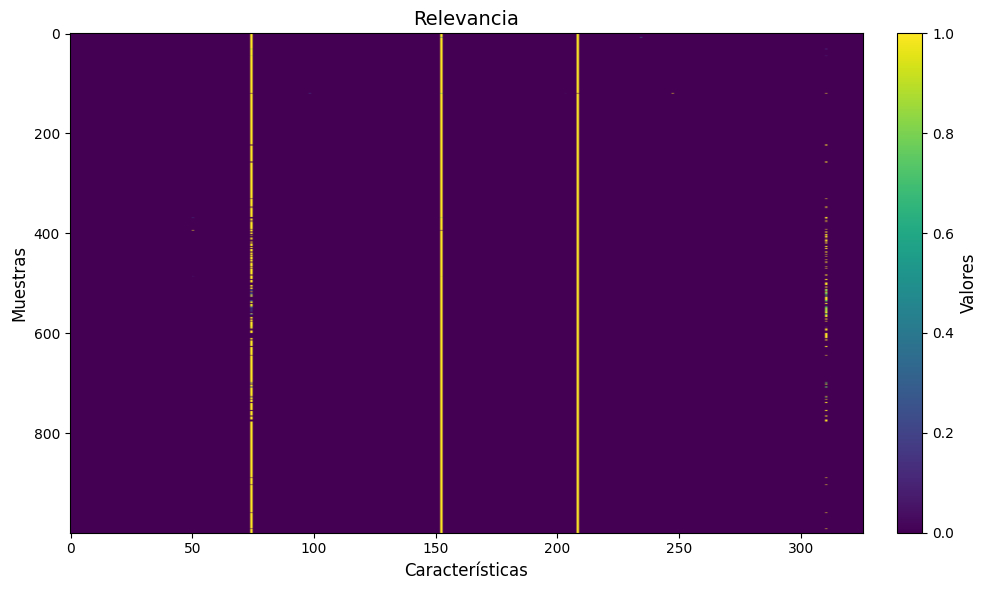

In [ ]:
min_val = np.min(mask)
max_val = np.max(mask)

# Crear figura
fig, ax = plt.subplots(figsize=(10, 6))

# Gráfico de la máscara
im = ax.imshow(mask, aspect='auto', cmap='viridis', vmin=min_val, vmax=max_val)
ax.set_title("Relevancia", fontsize=14)
ax.set_xlabel("Características", fontsize=12)
ax.set_ylabel("Muestras", fontsize=12)

# Barra de color
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label("Valores", fontsize=12)

# Mostrar la gráfica
plt.tight_layout()
plt.savefig('Mask.pdf')
plt.show()

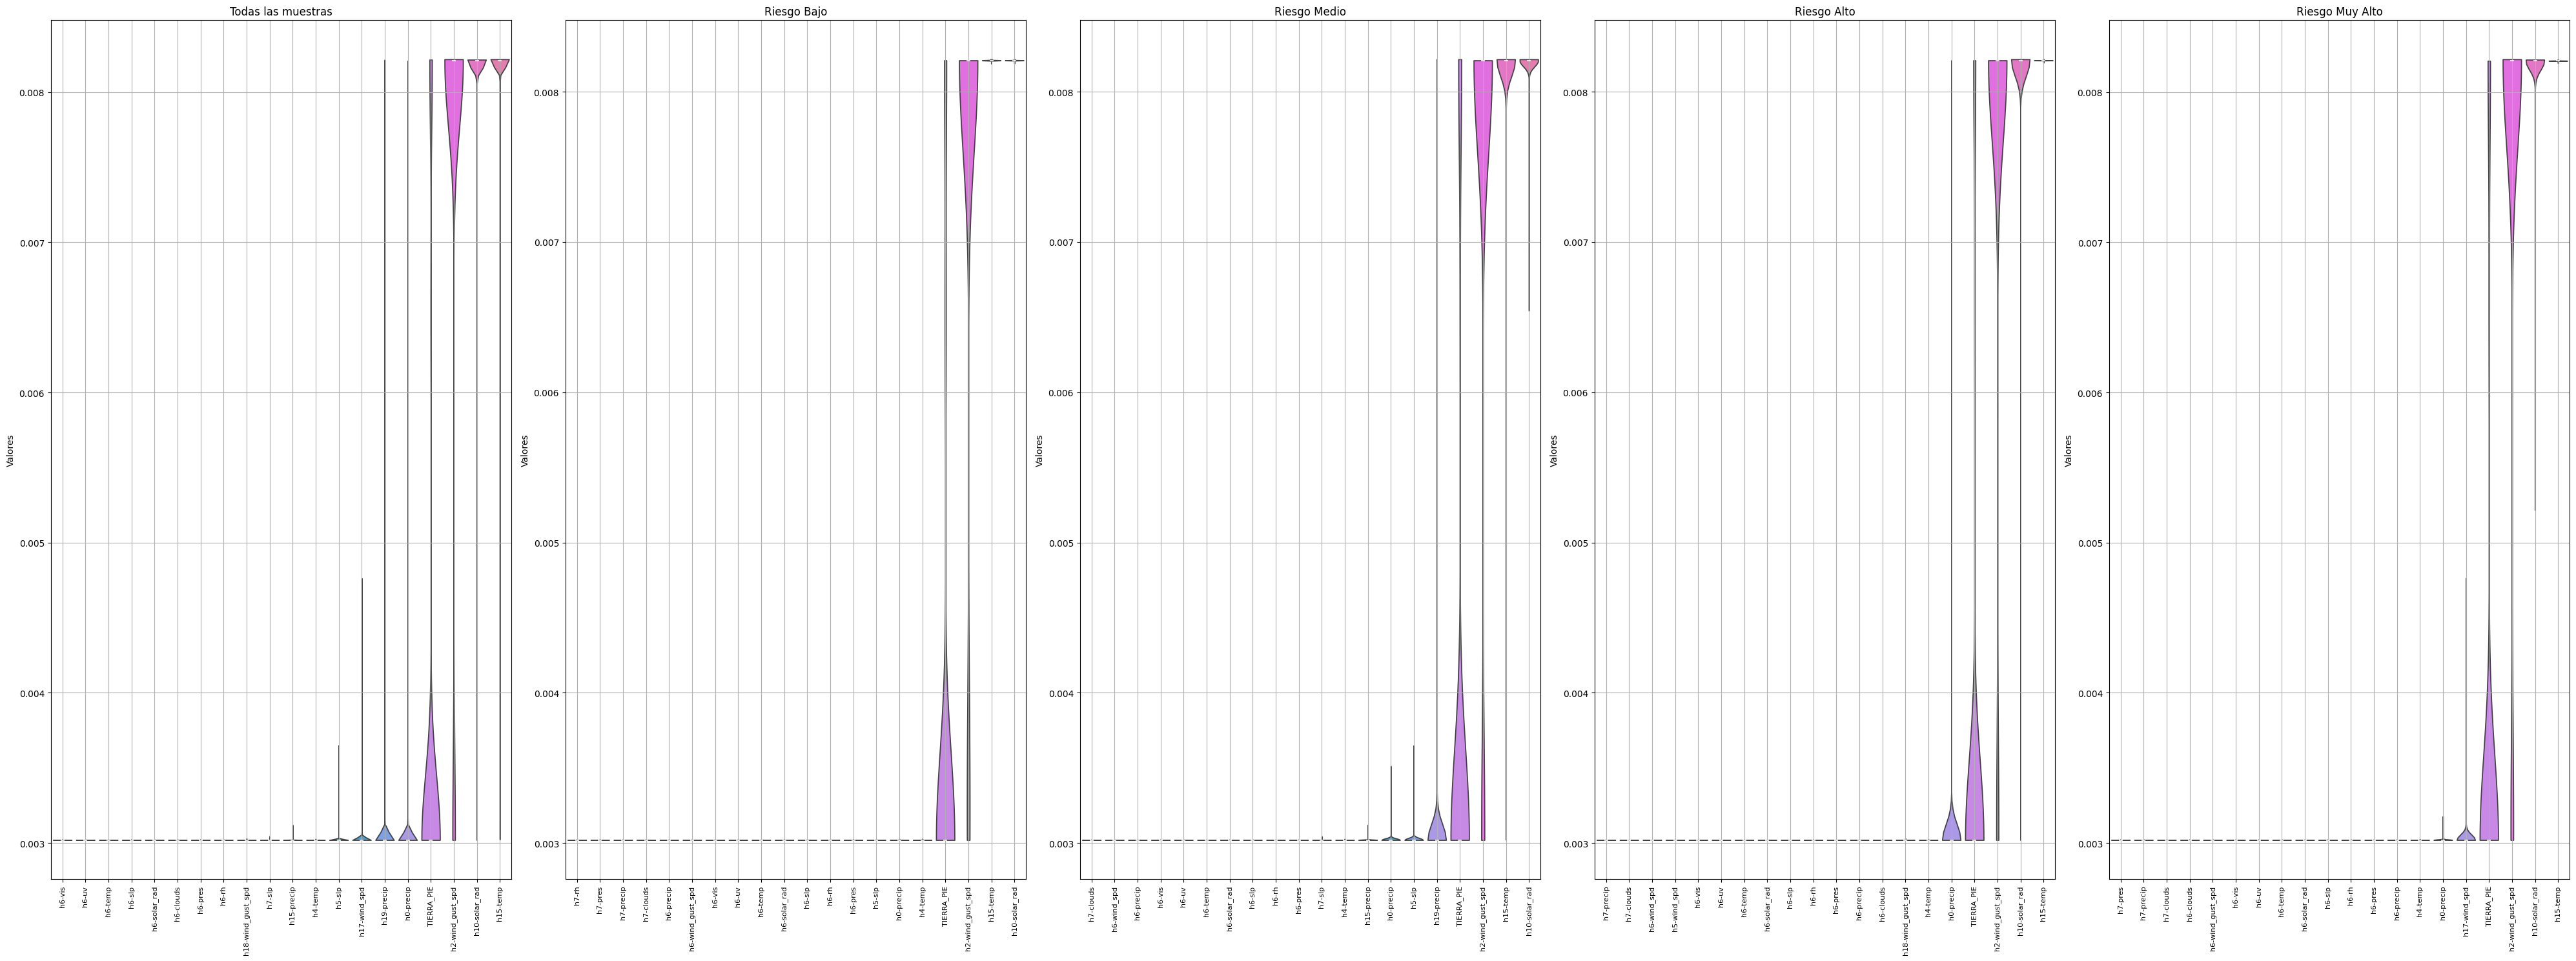

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.special import softmax

# Asume que `mask`, `y_categorized`, y `columns` ya están definidos
normalized_mask = softmax(mask, axis=1)
class_titles = ['Todas las muestras', 'Riesgo Bajo', 'Riesgo Medio', 'Riesgo Alto', 'Riesgo Muy Alto']
columns=df.columns
# Crear la figura con 1 fila y 5 columnas
fig, axes = plt.subplots(1, 5, figsize=(40, 15))

for selected_class, ax in enumerate(axes):
    if selected_class == 0:
        # Todas las muestras
        column_relevance = np.mean(normalized_mask, axis=0)
        top_20_indices = np.argsort(column_relevance)[-20:]
        top_20_columns = [columns[i] for i in top_20_indices]
        top_20_mask = normalized_mask[:, top_20_indices]
        sns.violinplot(data=top_20_mask, inner="box", cut=0, ax=ax)
        ax.set_title(class_titles[selected_class])
    else:
        # Filtrar por clase
        class_idx = selected_class - 1
        if np.any(y_categorized == class_idx):
            column_relevance = np.mean(normalized_mask[y_categorized == class_idx], axis=0)
            top_20_indices = np.argsort(column_relevance)[-20:]
            top_20_columns = [columns[i] for i in top_20_indices]
            top_20_mask = normalized_mask[y_categorized == class_idx][:, top_20_indices]
            sns.violinplot(data=top_20_mask, inner="box", cut=0, ax=ax)
            ax.set_title(class_titles[selected_class])
        else:
            ax.text(0.5, 0.5, f'No hay datos para\n{class_titles[selected_class]}',
                    fontsize=14, ha='center', va='center')
            ax.set_axis_off()

    ax.set_xticks(range(len(top_20_columns)))
    ax.set_xticklabels(top_20_columns, rotation=90, fontsize=8)
    ax.set_ylabel("Valores", fontsize=10)
    ax.grid(True)

plt.tight_layout()
plt.savefig('violin.pdf')
plt.show()


In [ ]:
def process_dataframe(redmt, df, label_encoders, df1, ind,tip,s,scolumns):
    """
    Procesa un DataFrame `redmt` usando coordenadas y LabelEncoders, y devuelve un DataFrame resultante.

    Args:
        redmt (pd.DataFrame): DataFrame base con información de referencia.
        df (pd.DataFrame): DataFrame con coordenadas para encontrar vecinos cercanos.
        label_encoders (dict): Diccionario con `LabelEncoder` para columnas categóricas.
        df1 (pd.DataFrame): DataFrame con la fila de interés.
        ind (int): Índice de la fila de interés en `df1`.

    Returns:
        pd.DataFrame: DataFrame resultante con los datos procesados.
    """
    # Convertir las columnas de fecha
    df1['inicio'] = pd.to_datetime(df1['inicio'])
    df1['FECHA_C'] = df1['inicio'].dt.to_period('M')

    # Seleccionar la fila de interés de `df1` (por índice)
    row_of_interest = df1.loc[[ind]].copy()
    #print('1',row_of_interest[['LATITUD','LONGITUD']].values)
    #row_of_interest[scolumns]=np.nan
    # Vaciar los valores de las columnas en `scolumns`
    #for col in scolumns:
    #    if col in row_of_interest.columns:
    #        row_of_interest[col] = np.nan

    # Extraer las listas de coordenadas y equipos desde la fila de interés
    if s==0:
        #aux = eval(row_of_interest.loc[ind, 'TRAMOS_AGUAS_ABAJO'])
        aux=  list(eval(row_of_interest.loc[ind,'TRAMOS_AGUAS_ABAJO_CODES']))
    else:
        aux = eval(row_of_interest.loc[ind, 'EQUIPOS_PUNTOS'])


    # DataFrame para almacenar las nuevas filas
    new_rows = []
    # Iterar sobre cada elemento de `aux` para filtrar y duplicar
    for i in aux:
        # Filtrar `redmt` según las condiciones dadas
        if s==0:
            filtered_row = redmt[
              (redmt['FECHA_C'] == row_of_interest.loc[ind, 'FECHA_C']) &
              (redmt['equipo_ope']== i)
                ]

        else:
            filtered_row = redmt[
              (redmt['FECHA_C'] == row_of_interest.loc[ind, 'FECHA_C']) &
              (redmt['LATITUD'] == i[0]) &
              (redmt['LONGITUD'] == i[1])]


        #print('2',filtered_row[['LATITUD','LONGITUD']].values)
        # Si hay filas que cumplen la condición, reemplazar columnas en la fila de interés
        if not filtered_row.empty:
            for _, row in filtered_row.iterrows():
                #print(3,redmt.columns)
                # Crear una copia de la fila de interés y reemplazar las columnas correspondientes
                temp_row = row_of_interest.copy()
                temp_row[redmt.columns] = row.values  # Reemplaza las columnas de redmt
                #temp_row['LATITUD'] = np.float64(i[0])  # Asegura precisión en la asignación
                #temp_row['LONGITUD'] = np.float64(i[1])
                new_rows.append(temp_row)
    if not new_rows:
        # Retornar un DataFrame vacío con las columnas esperadas
        aux1=pd.DataFrame(columns=df1.columns)
        aux1.drop(['inicio_evento', 'h0-solar_rad', 'h0-uv', 'h1-solar_rad', 'h1-uv', 'h2-solar_rad', 'h2-uv', 'h3-solar_rad', 'h3-uv',
            'h4-solar_rad', 'h4-uv', 'h5-solar_rad', 'h5-uv', 'h19-solar_rad', 'h19-uv', 'h20-solar_rad', 'h20-uv',
            'h21-solar_rad', 'h21-uv', 'h22-solar_rad', 'h22-uv', 'h23-solar_rad', 'h23-uv', 'evento', 'fin', 'inicio',
            'cnt_usus', 'DEP', 'MUN', 'FECHA', 'NIVEL_C', 'VALOR_C', 'TRAMOS_AGUAS_ABAJO', 'EQUIPOS_PUNTOS',
            'PUNTOS_POLIGONO', 'LONGITUD2', 'LATITUD2', 'FECHA_C','TRAMOS_AGUAS_ABAJO_CODES','ORDER_'],
           inplace=True, axis=1)
        aux1.drop(target, axis=1, inplace=True)
        return pd.DataFrame(columns=scolumns).values,aux1
    # Concatenar todas las nuevas filas generadas
    result_df = pd.concat(new_rows, ignore_index=True)
    result_df=enriquecer_eventos_con_rayos_y_vegetacion(result_df, Rayos, Vegetacion,ventana_dias= 24,veg_vars=['NOM_COMUN','ESTADO_INICIAL','LADO_RED','DAP_ESTIM','LONG_INTER','TIPO_INTER', 'NIVEL_RIES'])

    bad_types = (list, dict, set)
    hashable_cols = [c for c in result_df.columns
                    if not result_df[c].apply(lambda v: isinstance(v, bad_types)).any()]
    result_df.drop_duplicates(subset=hashable_cols, inplace=True)

    result_df['LATITUD'] = result_df['LATITUD'].astype('float64')
    result_df['LONGITUD'] = result_df['LONGITUD'].astype('float64')

    result_df1 =result_df.copy()
    result_df1['LATITUD'] = result_df1['LATITUD'].astype('float64')
    result_df1['LONGITUD'] = result_df1['LONGITUD'].astype('float64')


    # Codificar las columnas categóricas usando los LabelEncoder definidos en `label_encoders`
    for col, le in label_encoders.items():
      if col in result_df.columns:  # Verificar que la columna exista en `result_df`
        if col in redmt.columns:  # Si la columna pertenece a redmt
            result_df[col] = result_df[col].apply(
                lambda x: le.transform([x])[0] if x in le.classes_ else np.nan
            )
        else:  # Si no pertenece a redmt
            result_df[col] = result_df[col].fillna("no aplica")  # Rellenar NaN con "no aplica"
            result_df[col] = result_df[col].apply(
                lambda x: le.transform([x])[0] if x in le.classes_ else 0
            )


    # Reemplazar valores NaN en columnas categóricas usando el valor más cercano
    categorical_columns = redmt.select_dtypes(include=['object', 'category']).columns

    # Preparar las coordenadas (LATITUD y LONGITUD) de `df`
    df_coords = df[['LATITUD', 'LONGITUD']].dropna()

    # Modelo de vecinos más cercanos
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(df_coords)

    # Recorrer las columnas categóricas de result_df
    for col in result_df.columns:
        if col in redmt.columns:  # Verificar si la columna pertenece a redmt
            nan_indices = result_df[result_df[col].isna()].index  # Índices con NaN en la columna
            for idx in nan_indices:
                # Coordenadas de la fila con NaN
                query_coords = result_df.loc[idx, ['LATITUD', 'LONGITUD']].values.reshape(1, -1)
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", message="X does not have valid feature names, but NearestNeighbors was fitted with feature names")
                    distance, neighbor_idx = nbrs.kneighbors(query_coords)
                closest_idx = df_coords.iloc[neighbor_idx[0][0]].name
                # Reemplazar el valor NaN con el valor del vecino más cercano
                result_df.at[idx, col] = df.at[closest_idx, col]
        #else:
            #result_df[col].astype(str).fillna("no aplica",inplace=True)
    for col in NUMERIC_COLUMNS:
        max_value = max_values[col]
        # Rellenar valores y ajustar el tipo de datos
        result_df[col] = result_df[col].fillna(-10 * max_value).astype('float64')

    result_df['tipo_equi_ope'] = tip
    result_df.drop(['inicio_evento', 'h0-solar_rad', 'h0-uv', 'h1-solar_rad', 'h1-uv', 'h2-solar_rad', 'h2-uv', 'h3-solar_rad', 'h3-uv',
            'h4-solar_rad', 'h4-uv', 'h5-solar_rad', 'h5-uv', 'h19-solar_rad', 'h19-uv', 'h20-solar_rad', 'h20-uv',
            'h21-solar_rad', 'h21-uv', 'h22-solar_rad', 'h22-uv', 'h23-solar_rad', 'h23-uv', 'evento', 'fin', 'inicio',
            'cnt_usus', 'DEP', 'MUN', 'FECHA', 'NIVEL_C', 'VALOR_C', 'TRAMOS_AGUAS_ABAJO', 'EQUIPOS_PUNTOS',
            'PUNTOS_POLIGONO', 'LONGITUD2', 'LATITUD2', 'FECHA_C','TRAMOS_AGUAS_ABAJO_CODES','ORDER_'],
           inplace=True, axis=1)
    result_df.drop(target, axis=1, inplace=True)
    result_df1.drop(['inicio_evento', 'h0-solar_rad', 'h0-uv', 'h1-solar_rad', 'h1-uv', 'h2-solar_rad', 'h2-uv', 'h3-solar_rad', 'h3-uv',
            'h4-solar_rad', 'h4-uv', 'h5-solar_rad', 'h5-uv', 'h19-solar_rad', 'h19-uv', 'h20-solar_rad', 'h20-uv',
            'h21-solar_rad', 'h21-uv', 'h22-solar_rad', 'h22-uv', 'h23-solar_rad', 'h23-uv', 'evento', 'fin', 'inicio',
            'cnt_usus', 'DEP', 'MUN', 'FECHA', 'NIVEL_C', 'VALOR_C', 'TRAMOS_AGUAS_ABAJO', 'EQUIPOS_PUNTOS',
            'PUNTOS_POLIGONO', 'LONGITUD2', 'LATITUD2', 'FECHA_C','TRAMOS_AGUAS_ABAJO_CODES','ORDER_'],
           inplace=True, axis=1)
    result_df1.drop(target, axis=1, inplace=True)
    result_df1.drop_duplicates(inplace=True)
    result_df.drop_duplicates(inplace=True)
    return result_df.values,result_df1

In [ ]:

redmt = pd.read_pickle('/content/CHEC/Data_CHEC/REDMT_1.pkl')
redmt['FECHA']=pd.to_datetime(redmt['FECHA'])
redmt['FECHA_C']=redmt['FECHA'].dt.to_period('M')
redmt.rename(columns={'CODE':'equipo_ope'}, inplace=True)
apoyos = pd.read_pickle('/content/CHEC/Data_CHEC/APOYOS.pkl')
apoyos['FECHA']=pd.to_datetime(apoyos['FECHA'])
apoyos['FECHA_C']=apoyos['FECHA'].dt.to_period('M')
apoyos.rename(columns={'CODE':'equipo_ope'}, inplace=True)
switches = pd.read_pickle('/content/CHEC/Data_CHEC/SWITCHES.pkl')
switches['FECHA']=pd.to_datetime(switches['FECHA'])
switches['FECHA_C']=switches['FECHA'].dt.to_period('M')
trafos = pd.read_pickle('/content/CHEC/Data_CHEC/TRAFOS.pkl')
trafos['FECHA']=pd.to_datetime(trafos['FECHA'])
trafos['FECHA_C']=trafos['FECHA'].dt.to_period('M')
scolumns = list(
    set(redmt.columns)
    .union(set(apoyos.columns))
    .union(set(trafos.columns))
    .union(set(switches.columns))
)

NameError: name 'pd' is not defined

In [ ]:
ind=0
a1,a1_df = process_dataframe(trafos, df, label_encoders, df1, ind=ind,tip=2,s=1,scolumns=scolumns)
del trafos
a2,a2_df = process_dataframe(switches, df, label_encoders, df1, ind=ind,tip=0,s=1,scolumns=scolumns)
del switches
a3,a3_df = process_dataframe(redmt, df, label_encoders, df1, ind=ind,tip=1,s=0,scolumns=scolumns)
del redmt
a4,a4_df = process_dataframe(apoyos, df, label_encoders, df1, ind=ind,tip=2,s=1,scolumns=scolumns)
del apoyos
columns=df.columns
arrays_to_concatenate = [arr for arr in (a1, a2, a3, a4) if arr.size > 0]
a = np.concatenate(arrays_to_concatenate, axis=0)
y_e=clf.predict(a)
y_e=y_e.flatten()

In [ ]:
pd.concat([a1_df,a2_df,a3_df,a4_df],axis=0)['LONG_INTER_median']